Imports & basic config

In [55]:
import numpy as np
import pandas as pd
import librosa
import pretty_midi
import networkx as nx
import matplotlib.pyplot as plt

# Audio config 
SR = 44100
FRAME_LENGTH = 1024
HOP_LENGTH = 512
EPS = 1e-10

MIDI → pitch-class chord sequence

In [56]:
# MIDI → full-pitch chord sequence (paper method)

def midi_chord_sequence_fullpitch(midi_path):
    """
    From MIDI -> sequence of chords in *full MIDI pitch* space (0..127).
    - Each chord = all pitches starting at the same time (exact start times).
    - Chords are ordered by time.
    - Consecutive duplicate chords are merged.
    This matches the construction in Di Marco et al.
    """
    pm = pretty_midi.PrettyMIDI(midi_path)

    # Map start_time -> list of pitches across all non-drum instruments
    time_to_pitches = {}

    for inst in pm.instruments:
        if inst.is_drum:
            continue
        for note in inst.notes:
            t = note.start
            if t not in time_to_pitches:
                time_to_pitches[t] = []
            time_to_pitches[t].append(note.pitch)

    if not time_to_pitches:
        return []

    # Build ordered chord list
    chords = []
    for t in sorted(time_to_pitches.keys()):
        chord = tuple(sorted(set(time_to_pitches[t])))
        if len(chord) > 0:
            chords.append(chord)

    # Compress consecutive duplicates
    final = []
    prev = None
    for c in chords:
        if c != prev:
            final.append(c)
            prev = c

    return final


In [57]:
def midi_chord_sequence_fullpitch(midi_path, time_tol=1e-3):
    """
    From MIDI -> sequence of chords in *full MIDI pitch* space (0..127).
    Each chord is a tuple of pitches; consecutive duplicates merged.
    Follows the construction in Di Marco et al. (per instrument/channel).
    """
    pm = pretty_midi.PrettyMIDI(midi_path)

    chords_all = []

    for inst in pm.instruments:
        if inst.is_drum:
            continue

        # Collect notes for this instrument and sort by onset
        notes = sorted(inst.notes, key=lambda n: n.start)
        if not notes:
            continue

        time_slices = []
        current_time = None
        current_chord = []

        for n in notes:
            t = n.start
            p = n.pitch
            if current_time is None:
                current_time = t
                current_chord = [p]
            elif abs(t - current_time) <= time_tol:
                current_chord.append(p)
            else:
                # close previous slice (full pitches, no mod 12)
                chord = tuple(sorted(set(current_chord)))
                if len(chord) > 0:
                    time_slices.append(chord)
                current_time = t
                current_chord = [p]

        if current_chord:
            chord = tuple(sorted(set(current_chord)))
            if len(chord) > 0:
                time_slices.append(chord)

        # compress consecutive duplicates in this instrument
        prev = None
        for c in time_slices:
            if c != prev:
                chords_all.append(c)
                prev = c

    return chords_all


Audio → chroma chord sequence

In [58]:
CHROMA_THRESH = 0.3  # relative threshold within frame

def chroma_chord_sequence(y, sr=SR, hop_length=HOP_LENGTH, thresh=CHROMA_THRESH):
    """
    From audio -> chroma -> sequence of chords in pitch-class space (0..11).
    Each chord is a tuple of pitch classes; consecutive duplicates merged.
    """
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length)
    T = chroma.shape[1]

    chords = []
    prev_chord = None

    for t in range(T):
        frame = chroma[:, t]
        if frame.max() < 1e-6:
            active = ()
        else:
            act = np.where(frame >= thresh * frame.max())[0]
            active = tuple(sorted(set(act.tolist())))

        if active != prev_chord and len(active) > 0:
            chords.append(active)
            prev_chord = active

    return chords


Build graph from chord sequence (shared for MIDI & audio)

In [59]:
def build_chord_transition_graph(chords):
    """
    chords: list of tuples of integer pitches (e.g., MIDI notes or pitch classes)
    Returns DiGraph with edges weighted by transition counts.
    No self-loops.
    """
    G = nx.DiGraph()
    for chord_a, chord_b in zip(chords[:-1], chords[1:]):
        for i in chord_a:
            for j in chord_b:
                if i == j:
                    continue  # no self-loops
                if G.has_edge(i, j):
                    G[i][j]["weight"] += 1
                else:
                    G.add_edge(i, j, weight=1)
    return G



def weighted_reciprocity(G):
    W = 0.0
    W_bidir = 0.0
    for u, v, data in G.edges(data=True):
        w_uv = data["weight"]
        W += w_uv
        if G.has_edge(v, u):
            w_vu = G[v][u]["weight"]
            W_bidir += min(w_uv, w_vu)
    if W == 0:
        return 0.0
    return W_bidir / W


def shuffle_outgoing_weights_preserve_strength(G, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    H = G.copy()
    for u in H.nodes():
        out_edges = list(H.out_edges(u, data=True))
        if len(out_edges) <= 1:
            continue
        weights = [d["weight"] for _, _, d in out_edges]
        rng.shuffle(weights)
        for (idx, (src, dst, data)) in enumerate(out_edges):
            data["weight"] = float(weights[idx])
    return H


def normalized_weighted_reciprocity(G, n_null=20):
    r_real = weighted_reciprocity(G)
    if G.number_of_edges() == 0:
        return r_real, 0.0, 0.0

    r_null_vals = []
    for _ in range(n_null):
        H = shuffle_outgoing_weights_preserve_strength(G)
        r_null_vals.append(weighted_reciprocity(H))

    r_null = float(np.mean(r_null_vals))
    if r_null >= 1.0:
        rho = 0.0
    else:
        rho = (r_real - r_null) / (1 - r_null)
    return r_real, r_null, rho


def node_entropy(G, u):
    out_edges = list(G.out_edges(u, data=True))
    k = len(out_edges)
    if k <= 1:
        return 0.0
    weights = np.array([d["weight"] for _, _, d in out_edges], dtype=float)
    p = weights / (weights.sum() + EPS)
    H = -np.sum(p * np.log(p + EPS))
    H_max = np.log(k + EPS)
    return H / (H_max + EPS)


def mean_node_entropy(G):
    if G.number_of_nodes() == 0:
        return 0.0
    entropies = [node_entropy(G, u) for u in G.nodes()]
    return float(np.mean(entropies))


def global_efficiency_unweighted(G):
    if G.number_of_nodes() <= 1:
        return 0.0
    sp = dict(nx.all_pairs_shortest_path_length(G))
    nodes = list(G.nodes())
    s = 0.0
    count = 0
    for i in nodes:
        for j in nodes:
            if i == j:
                continue
            d = sp.get(i, {}).get(j, np.inf)
            if np.isfinite(d) and d > 0:
                s += 1.0 / d
                count += 1
    return float(s / count) if count > 0 else 0.0


def global_efficiency_weighted(G):
    if G.number_of_nodes() <= 1:
        return 0.0
    H = G.copy()
    for u, v, data in H.edges(data=True):
        data["cost"] = 1.0 / float(data["weight"])

    sp = dict(nx.all_pairs_dijkstra_path_length(H, weight="cost"))
    nodes = list(H.nodes())
    s = 0.0
    count = 0
    for i in nodes:
        for j in nodes:
            if i == j:
                continue
            d = sp.get(i, {}).get(j, np.inf)
            if np.isfinite(d) and d > 0:
                s += 1.0 / d
                count += 1
    return float(s / count) if count > 0 else 0.0


def interval_embedding_12d(G):
    """
    12D interval profile over pitch classes; L2-normalized.
    """
    counts = np.zeros(12, dtype=float)
    for u, v, data in G.edges(data=True):
        w = float(data["weight"])
        interval = (v - u) % 12
        counts[interval] += w
    norm = np.linalg.norm(counts)
    if norm > 0:
        return counts / norm
    return counts


Convenience wrappers for “MIDI network” and “audio network”

In [60]:
def compute_midi_network_metrics(midi_path):
    # Use full MIDI pitches for the graph, as in the paper
    chords = midi_chord_sequence_fullpitch(midi_path)
    G = build_chord_transition_graph(chords)

    metrics = {}
    metrics["n_nodes"] = G.number_of_nodes()
    metrics["n_edges"] = G.number_of_edges()
    metrics["density"] = nx.density(G)

    r_real, r_null, rho = normalized_weighted_reciprocity(G)
    metrics["r_real"] = r_real
    metrics["r_null"] = r_null
    metrics["rho_norm"] = rho

    metrics["mean_entropy"] = mean_node_entropy(G)
    metrics["eff_unweighted"] = global_efficiency_unweighted(G)
    metrics["eff_weighted"] = global_efficiency_weighted(G)

    # Intervals now come from full pitches, then mod 12
    metrics["interval_vec"] = interval_embedding_12d(G)

    metrics["graph"] = G
    return metrics


Visualize interval profiles (MIDI vs Audio)

In [61]:
def plot_interval_profiles(iv_midi, iv_audio, title="Interval profile"):
    interval_names = [
        "0 (unison)",
        "1 (m2)",
        "2 (M2)",
        "3 (m3)",
        "4 (M3)",
        "5 (P4)",
        "6 (TT)",
        "7 (P5)",
        "8 (m6)",
        "9 (M6)",
        "10 (m7)",
        "11 (M7)",
    ]

    x = np.arange(12)
    width = 0.35

    plt.figure(figsize=(10, 4))
    plt.bar(x - width/2, iv_midi,  width, label="MIDI")
    plt.bar(x + width/2, iv_audio, width, label="Audio (chroma)")

    plt.xticks(x, interval_names, rotation=45, ha="right")
    plt.ylabel("L2-normalized weight")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


visualize the graphs

In [62]:
def plot_midi_graph(G, title=""):
    if G.number_of_nodes() == 0:
        print("Empty graph")
        return

    pos = nx.spring_layout(G, seed=0)
    weights = np.array([d["weight"] for _, _, d in G.edges(data=True)], dtype=float)
    if len(weights) > 0:
        w_norm = 1 + 4 * (weights - weights.min()) / (weights.max() - weights.min() + EPS)
    else:
        w_norm = 1.0

    # MIDI note -> note name (e.g., 60 -> C4)
    labels = {n: pretty_midi.note_number_to_name(n) for n in G.nodes()}

    plt.figure(figsize=(6, 6))
    nx.draw_networkx_nodes(G, pos, node_size=400)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
    nx.draw_networkx_edges(G, pos, width=w_norm, arrows=True, arrowstyle="->")
    plt.title(title)
    plt.axis("off")
    plt.show()


In [63]:
def plot_pitchclass_graph(G, title=""):
    if G.number_of_nodes() == 0:
        print("Empty graph")
        return

    pos = nx.spring_layout(G, seed=0)
    weights = np.array([d["weight"] for _, _, d in G.edges(data=True)], dtype=float)
    if len(weights) > 0:
        # normalize edge widths for visibility
        w_norm = 1 + 4 * (weights - weights.min()) / (weights.max() - weights.min() + EPS)
    else:
        w_norm = 1.0

    plt.figure(figsize=(5, 5))
    nx.draw_networkx_nodes(G, pos, node_size=500)
    nx.draw_networkx_labels(G, pos, labels={n: str(n) for n in G.nodes()})
    nx.draw_networkx_edges(G, pos, width=w_norm, arrows=True, arrowstyle="->")
    plt.title(title)
    plt.axis("off")
    plt.show()

General helper to compare one pair

In [64]:
def compare_midi_audio_pair(midi_path, audio_path, label="piece"):
    print(f"=== {label} ===")
    midi_metrics = compute_midi_network_metrics(midi_path)
    audio_metrics = compute_audio_network_metrics(audio_path)

    compare_keys = [
        "n_nodes",
        "n_edges",
        "density",
        "r_real",
        "r_null",
        "rho_norm",
        "mean_entropy",
        "eff_unweighted",
        "eff_weighted",
    ]

    rows = []
    for domain, metrics in [("MIDI", midi_metrics), ("Audio", audio_metrics)]:
        row = {"piece": label, "domain": domain}
        for k in compare_keys:
            row[k] = metrics[k]
        rows.append(row)

    df = pd.DataFrame(rows).set_index(["piece", "domain"])

    # cosine similarity of interval vectors
    iv_midi  = midi_metrics["interval_vec"]
    iv_audio = audio_metrics["interval_vec"]
    cosine_sim = float(
        np.dot(iv_midi, iv_audio) /
        (np.linalg.norm(iv_midi) * np.linalg.norm(iv_audio) + EPS)
    )

    print("Cosine similarity of interval profiles:", cosine_sim)
    display(df)

    # plots
    plot_interval_profiles(iv_midi, iv_audio, title=f"Interval profile – {label}")
    plot_midi_graph(midi_metrics["graph"],  title=f"MIDI note network – {label}")
    plot_pitchclass_graph(audio_metrics["graph"], title=f"Audio chroma network – {label}")

    return {
        "midi": midi_metrics,
        "audio": audio_metrics,
        "df": df,
        "cosine": cosine_sim,
    }


### Playing away match: in the MIDI field

Run for Für Elise and create comparison table

In [65]:
# Paths
MIDI_PATH_FE = "beethoven_fr_elise_piano_version.mid"
AUDIO_PATH_FE = "beethoven_fr_elise_piano_version.wav"

=== Für Elise ===


c:\Users\emanu\miniconda3\envs\BasicPy\Lib\site-packages\pretty_midi\pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Cosine similarity of interval profiles: 0.8503699733010706


n_nodes  n_edges   density    r_real    r_null  rho_norm  \
piece     domain                                                             
Für Elise MIDI         56      269  0.087338  0.417123  0.234943  0.238126   
          Audio        12       73  0.553030  0.742857  0.385571  0.581493   

                  mean_entropy  eff_unweighted  eff_weighted  
piece     domain                                              
Für Elise MIDI        0.534693        0.344194      2.523089  
          Audio       0.882088        0.775253      7.842128

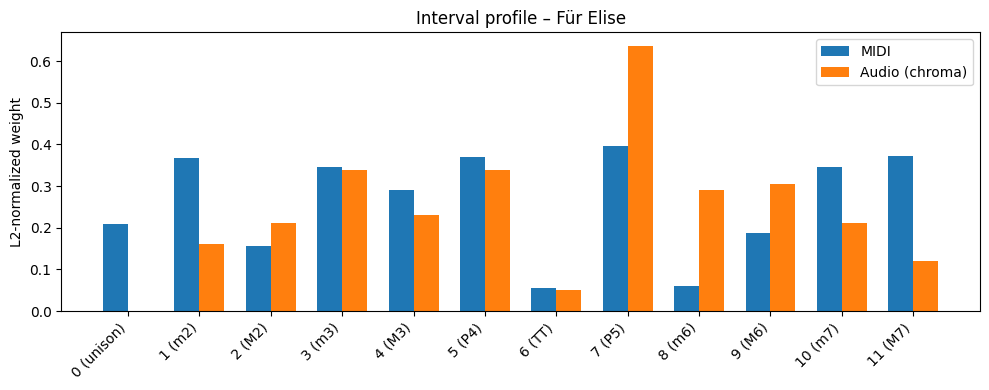

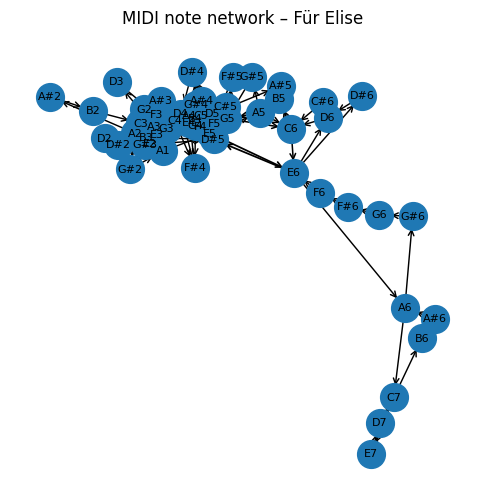

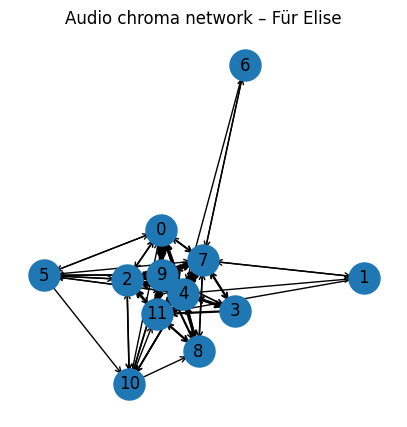

In [75]:
# Für Elise (for reference; you already did this once)
fe_results = compare_midi_audio_pair(
    MIDI_PATH_FE,
    AUDIO_PATH_FE,
    label="Für Elise"
)

Visualize interval profiles (MIDI vs Audio)

visualize the graphs

Common Ground: something in the between

In [67]:
MIDI_PATH_RICK  = "Never-Gonna-Give-You-Up-3.mid"
AUDIO_PATH_RICK = "never_gonna_give_you_up.wav"

=== Never Gonna Give You Up ===
Cosine similarity of interval profiles: 0.8165108635114895


n_nodes  n_edges   density    r_real  \
piece                   domain                                         
Never Gonna Give You Up MIDI         41      228  0.139024  0.743737   
                        Audio        12      132  1.000000  0.995714   

                                  r_null  rho_norm  mean_entropy  \
piece                   domain                                     
Never Gonna Give You Up MIDI    0.311953  0.627550      0.615626   
                        Audio   0.919896  0.946494      0.997772   

                                eff_unweighted  eff_weighted  
piece                   domain                                
Never Gonna Give You Up MIDI          0.417628      3.934737  
                        Audio         1.000000   2649.553030

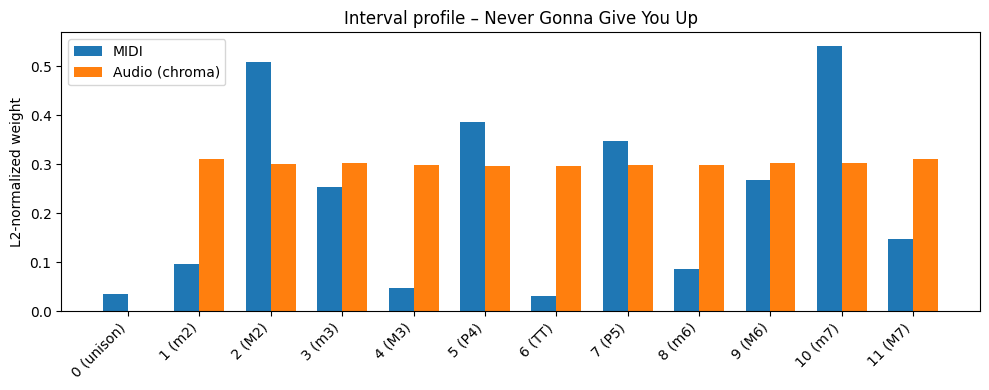

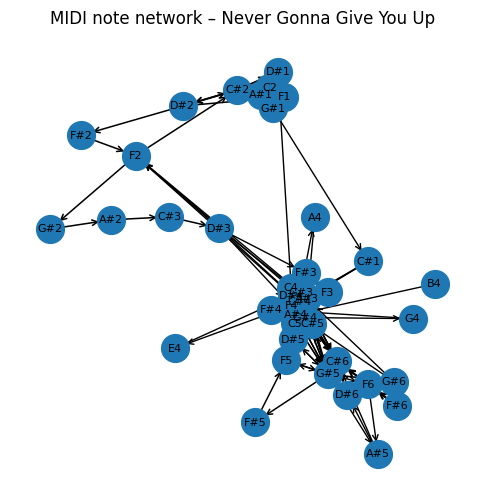

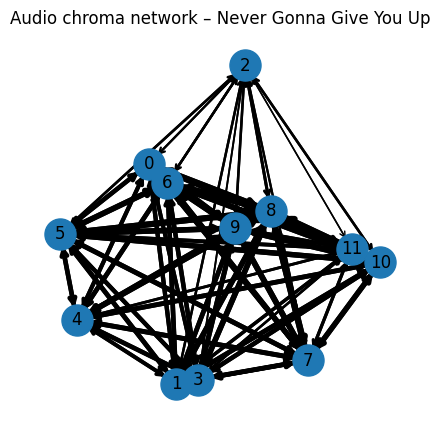

In [68]:
# Never Gonna Give You Up
rick_results = compare_midi_audio_pair(
    MIDI_PATH_RICK,
    AUDIO_PATH_RICK,
    label="Never Gonna Give You Up"
)

In [69]:
def plot_midi_graph(G, title=""):
    if G.number_of_nodes() == 0:
        print("Empty graph")
        return

    pos = nx.spring_layout(G, seed=0)
    weights = np.array([d["weight"] for _, _, d in G.edges(data=True)], dtype=float)
    if len(weights) > 0:
        w_norm = 1 + 4 * (weights - weights.min()) / (weights.max() - weights.min() + EPS)
    else:
        w_norm = 1.0

    # MIDI note -> note name (e.g., 60 -> C4)
    labels = {n: pretty_midi.note_number_to_name(n) for n in G.nodes()}

    plt.figure(figsize=(6, 6))
    nx.draw_networkx_nodes(G, pos, node_size=400)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
    nx.draw_networkx_edges(G, pos, width=w_norm, arrows=True, arrowstyle="->")
    plt.title(title)
    plt.axis("off")
    plt.show()


In [70]:
def compare_midi_audio_pair(midi_path, audio_path, label="piece"):
    print(f"=== {label} ===")
    midi_metrics = compute_midi_network_metrics(midi_path)
    audio_metrics = compute_audio_network_metrics(audio_path)

    compare_keys = [
        "n_nodes",
        "n_edges",
        "density",
        "r_real",
        "r_null",
        "rho_norm",
        "mean_entropy",
        "eff_unweighted",
        "eff_weighted",
    ]

    rows = []
    for domain, metrics in [("MIDI", midi_metrics), ("Audio", audio_metrics)]:
        row = {"piece": label, "domain": domain}
        for k in compare_keys:
            row[k] = metrics[k]
        rows.append(row)

    df = pd.DataFrame(rows).set_index(["piece", "domain"])

    # cosine similarity of interval vectors
    iv_midi  = midi_metrics["interval_vec"]
    iv_audio = audio_metrics["interval_vec"]
    cosine_sim = float(
        np.dot(iv_midi, iv_audio) /
        (np.linalg.norm(iv_midi) * np.linalg.norm(iv_audio) + EPS)
    )

    print("Cosine similarity of interval profiles:", cosine_sim)
    display(df)

    # plots
    plot_interval_profiles(iv_midi, iv_audio, title=f"Interval profile – {label}")
    plot_midi_graph(midi_metrics["graph"],  title=f"MIDI note network – {label}")
    plot_pitchclass_graph(audio_metrics["graph"], title=f"Audio chroma network – {label}")

    return {
        "midi": midi_metrics,
        "audio": audio_metrics,
        "df": df,
        "cosine": cosine_sim,
    }


=== Never Gonna Give You Up ===
Cosine similarity of interval profiles: 0.9151806830258301


n_nodes  n_edges   density    r_real  \
piece                   domain                                         
Never Gonna Give You Up MIDI         41      228  0.139024  0.743737   
                        Audio        12       95  0.719697  0.792564   

                                  r_null  rho_norm  mean_entropy  \
piece                   domain                                     
Never Gonna Give You Up MIDI    0.313341  0.626797      0.615626   
                        Audio   0.394912  0.657180      0.886146   

                                eff_unweighted  eff_weighted  
piece                   domain                                
Never Gonna Give You Up MIDI          0.417628      3.934737  
                        Audio         0.857323      9.689054

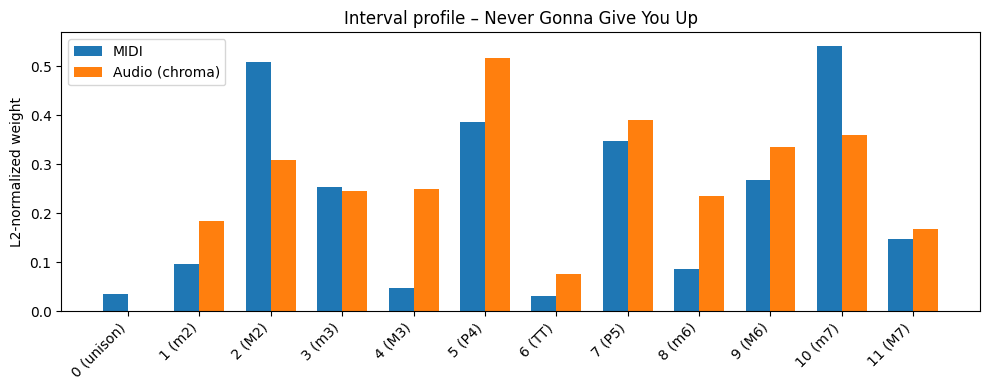

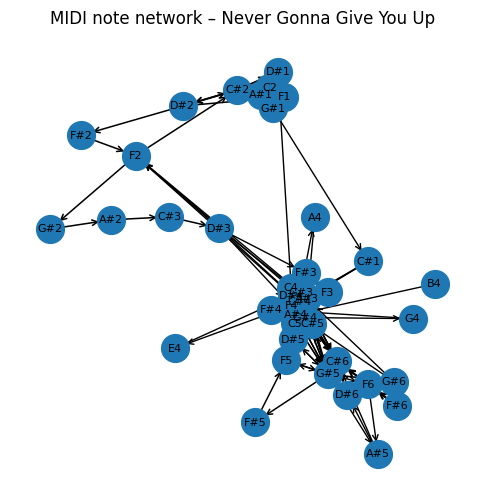

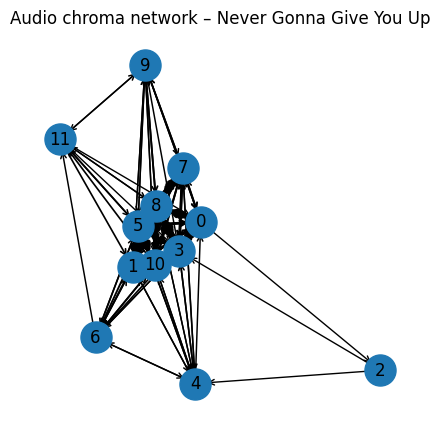

In [74]:
# Never Gonna Give You Up
rick_results = compare_midi_audio_pair(
    MIDI_PATH_RICK,
    AUDIO_PATH_RICK,
    label="Never Gonna Give You Up"
)

In [72]:
# Improved audio → chroma chord sequence (beat-sync + HPSS + top-K)

CHROMA_REL_THRESH = 0.5   # relative to frame max
CHROMA_MIN_ENERGY = 0.1   # absolute min energy to consider frame (0..1-ish)
CHROMA_TOP_K      = 2     # max number of pitch classes per beat


def chroma_chord_sequence_beat_harmonic(y, sr=SR,
                                        rel_thresh=CHROMA_REL_THRESH,
                                        min_energy=CHROMA_MIN_ENERGY,
                                        top_k=CHROMA_TOP_K):
    """
    From audio -> HARMONIC beat-synchronous chroma -> sequence of chords (pitch classes 0..11).
    Each chord is a tuple of up to 'top_k' strongest pitch classes per beat.
    Consecutive duplicate chords are merged.
    """
    # 1) HPSS: keep only harmonic component
    y_harm, y_perc = librosa.effects.hpss(y)

    # 2) Frame-level chroma on harmonic signal
    chroma = librosa.feature.chroma_cqt(y=y_harm, sr=sr)

    # 3) Beat tracking + beat-synchronous aggregation
    onset_env = librosa.onset.onset_strength(y=y_harm, sr=sr)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

    if beats.size == 0:
        # fallback: use frame-level chroma directly
        chroma_sync = chroma
    else:
        chroma_sync = librosa.util.sync(chroma, beats, aggregate=np.median)

    T = chroma_sync.shape[1]

    chords = []
    prev_chord = None

    for t in range(T):
        frame = chroma_sync[:, t]
        max_val = frame.max()

        # Skip very low-energy beats (silence or noise)
        if max_val < min_energy:
            active = ()
        else:
            # Relative thresholding
            mask = frame >= rel_thresh * max_val
            idxs = np.where(mask)[0]

            if idxs.size == 0:
                active = ()
            else:
                # If too many active, keep only top_k by magnitude
                if idxs.size > top_k:
                    # sort indices by frame value descending, take top_k
                    idxs_sorted = idxs[np.argsort(frame[idxs])[::-1][:top_k]]
                    idxs = np.sort(idxs_sorted)

                active = tuple(idxs.tolist())

        # compress consecutive duplicates, discard empty
        if active != prev_chord and len(active) > 0:
            chords.append(active)
            prev_chord = active

    return chords


In [73]:
def compute_audio_network_metrics(audio_path):
    y, sr = librosa.load(audio_path, sr=SR, mono=True)

    # NEW: use beat-synchronous harmonic chroma chord sequence
    chords = chroma_chord_sequence_beat_harmonic(y, sr=sr)

    G = build_chord_transition_graph(chords)

    metrics = {}
    metrics["n_nodes"] = G.number_of_nodes()
    metrics["n_edges"] = G.number_of_edges()
    metrics["density"] = nx.density(G)

    r_real, r_null, rho = normalized_weighted_reciprocity(G)
    metrics["r_real"] = r_real
    metrics["r_null"] = r_null
    metrics["rho_norm"] = rho

    metrics["mean_entropy"] = mean_node_entropy(G)
    metrics["eff_unweighted"] = global_efficiency_unweighted(G)
    metrics["eff_weighted"] = global_efficiency_weighted(G)

    metrics["interval_vec"] = interval_embedding_12d(G)
    metrics["graph"] = G
    return metrics



In [76]:
def _node_to_pitch_class(n):
    """
    Map a graph node to a pitch class in {0..11}.
    - If n is an int: treat it as a MIDI pitch or pitch class → n % 12
    - If n is a (pc, band) tuple: use pc
    """
    if isinstance(n, tuple) and len(n) >= 1:
        pc = int(n[0])
        return pc % 12
    else:
        return int(n) % 12


def interval_embedding_12d(G):
    """
    12D interval profile; L2-normalized.
    Works with:
      - MIDI note nodes (ints)
      - pitch-class nodes (ints 0..11)
      - multi-octave nodes (pc, band) tuples
    """
    counts = np.zeros(12, dtype=float)
    for u, v, data in G.edges(data=True):
        w = float(data["weight"])
        pc_u = _node_to_pitch_class(u)
        pc_v = _node_to_pitch_class(v)
        interval = (pc_v - pc_u) % 12
        counts[interval] += w
    norm = np.linalg.norm(counts)
    if norm > 0:
        return counts / norm
    return counts


In [77]:
# Multi-octave audio → chord sequence (harmonic, beat-sync, (pc, band) nodes)

MULTI_REL_THRESH = 0.5      # relative to frame max within beat
MULTI_MIN_ENERGY = 0.05     # min energy to consider beat
MULTI_TOP_K      = 4        # max (pc, band) pairs per beat
MULTI_N_OCTAVES  = 5        # number of octaves in CQT (adjustable)
MULTI_BASE_NOTE  = "C2"     # lowest note for CQT


def multi_octave_chord_sequence_beat_harmonic(
        y,
        sr=SR,
        rel_thresh=MULTI_REL_THRESH,
        min_energy=MULTI_MIN_ENERGY,
        top_k=MULTI_TOP_K,
        n_octaves=MULTI_N_OCTAVES,
        base_note=MULTI_BASE_NOTE,
        hop_length=HOP_LENGTH,
):
    """
    From audio -> harmonic multi-octave CQT -> beat-synchronous
    -> sequence of chords, where each "note" is (pc, band):

        pc   ∈ {0..11}
        band ∈ {0..n_octaves-1}

    Each beat yields up to 'top_k' (pc, band) nodes.
    Consecutive duplicate chords are merged.
    """
    # 1) HPSS: keep only harmonic component
    y_harm, y_perc = librosa.effects.hpss(y)

    # 2) Multi-octave CQT (12 bins per octave)
    C = librosa.cqt(
        y_harm,
        sr=sr,
        hop_length=hop_length,
        fmin=librosa.note_to_hz(base_note),
        n_bins=n_octaves * 12,
        bins_per_octave=12,
    )
    C_mag = np.abs(C)  # (n_bins, T_frames)

    # 3) Beat tracking
    onset_env = librosa.onset.onset_strength(y=y_harm, sr=sr, hop_length=hop_length)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

    if beats.size > 0:
        C_sync = librosa.util.sync(C_mag, beats, aggregate=np.median)  # (n_bins, T_beats)
    else:
        # fallback: use frame-level CQT if beat tracking fails
        C_sync = C_mag

    n_bins, T = C_sync.shape
    chords = []
    prev_chord = None

    for t in range(T):
        frame = C_sync[:, t]
        max_val = frame.max()

        # Skip low-energy beats
        if max_val < min_energy:
            active = ()
        else:
            # relative threshold
            mask = frame >= rel_thresh * max_val
            idxs = np.where(mask)[0]

            if idxs.size == 0:
                active = ()
            else:
                # keep at most top_k bins by magnitude
                if idxs.size > top_k:
                    idxs = idxs[np.argsort(frame[idxs])[::-1][:top_k]]

                # convert bin index -> (pc, band)
                active_nodes = []
                for idx in idxs:
                    pc = int(idx % 12)             # pitch class
                    band = int(idx // 12)          # octave band
                    active_nodes.append((pc, band))

                # deduplicate + sort for consistency
                active = tuple(sorted(set(active_nodes)))

        # compress consecutive duplicates & skip empty chords
        if active != prev_chord and len(active) > 0:
            chords.append(active)
            prev_chord = active

    return chords


In [78]:
def compute_audio_multiband_network_metrics(audio_path):
    """
    Audio-based multi-octave pitch-class network:
    - Nodes = (pc, band) tuples
    - Edges = transitions between chords of (pc, band) per beat
    """
    y, sr = librosa.load(audio_path, sr=SR, mono=True)

    chords = multi_octave_chord_sequence_beat_harmonic(y, sr=sr)
    G = build_chord_transition_graph(chords)

    metrics = {}
    metrics["n_nodes"] = G.number_of_nodes()
    metrics["n_edges"] = G.number_of_edges()
    metrics["density"] = nx.density(G)

    r_real, r_null, rho = normalized_weighted_reciprocity(G)
    metrics["r_real"] = r_real
    metrics["r_null"] = r_null
    metrics["rho_norm"] = rho

    metrics["mean_entropy"] = mean_node_entropy(G)
    metrics["eff_unweighted"] = global_efficiency_unweighted(G)
    metrics["eff_weighted"] = global_efficiency_weighted(G)

    metrics["interval_vec"] = interval_embedding_12d(G)
    metrics["graph"] = G
    return metrics


In [79]:
def plot_multiband_audio_graph(G, title=""):
    """
    Plot multi-octave audio graph with nodes labeled 'pc@band',
    where pc is pitch class (0..11) and band is octave band index.
    """
    if G.number_of_nodes() == 0:
        print("Empty graph")
        return

    pos = nx.spring_layout(G, seed=0)
    weights = np.array([d["weight"] for _, _, d in G.edges(data=True)], dtype=float)
    if len(weights) > 0:
        w_norm = 1 + 4 * (weights - weights.min()) / (weights.max() - weights.min() + EPS)
    else:
        w_norm = 1.0

    labels = {}
    for n in G.nodes():
        if isinstance(n, tuple) and len(n) >= 2:
            pc, band = n
            labels[n] = f"{pc}@{band}"
        else:
            labels[n] = str(n)

    plt.figure(figsize=(6, 6))
    nx.draw_networkx_nodes(G, pos, node_size=400)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
    nx.draw_networkx_edges(G, pos, width=w_norm, arrows=True, arrowstyle="->")
    plt.title(title)
    plt.axis("off")
    plt.show()


In [80]:
# Existing MIDI metrics
midi_metrics_rick = compute_midi_network_metrics(MIDI_PATH_RICK)

# Existing 12-node audio metrics (beat-sync chroma)
audio12_metrics_rick = compute_audio_network_metrics(AUDIO_PATH_RICK)

# NEW: multi-octave audio metrics
audio_multi_metrics_rick = compute_audio_multiband_network_metrics(AUDIO_PATH_RICK)

# Quick comparison of node/edge counts
pd.DataFrame([
    {"domain": "MIDI",        "n_nodes": midi_metrics_rick["n_nodes"],  "n_edges": midi_metrics_rick["n_edges"]},
    {"domain": "Audio12",     "n_nodes": audio12_metrics_rick["n_nodes"], "n_edges": audio12_metrics_rick["n_edges"]},
    {"domain": "AudioMulti",  "n_nodes": audio_multi_metrics_rick["n_nodes"], "n_edges": audio_multi_metrics_rick["n_edges"]},
]).set_index("domain")


n_nodes  n_edges
domain                      
MIDI             41      228
Audio12          12       95
AudioMulti       54     1447

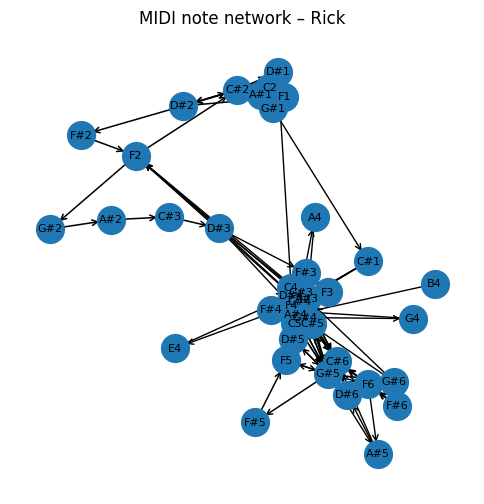

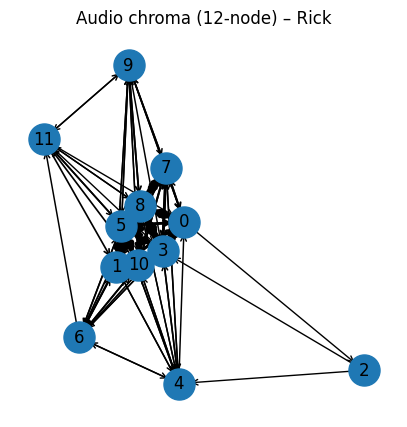

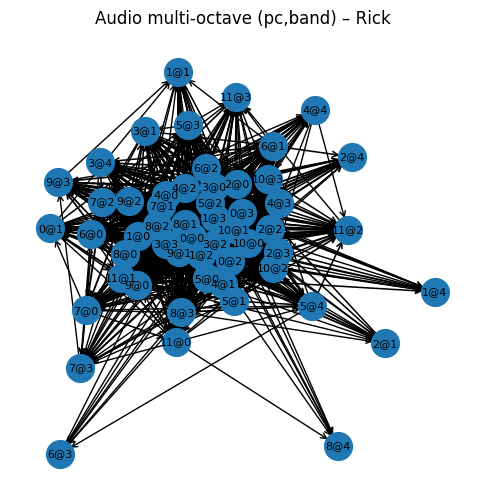

In [81]:
plot_midi_graph(midi_metrics_rick["graph"], title="MIDI note network – Rick")
plot_pitchclass_graph(audio12_metrics_rick["graph"], title="Audio chroma (12-node) – Rick")
plot_multiband_audio_graph(audio_multi_metrics_rick["graph"], title="Audio multi-octave (pc,band) – Rick")

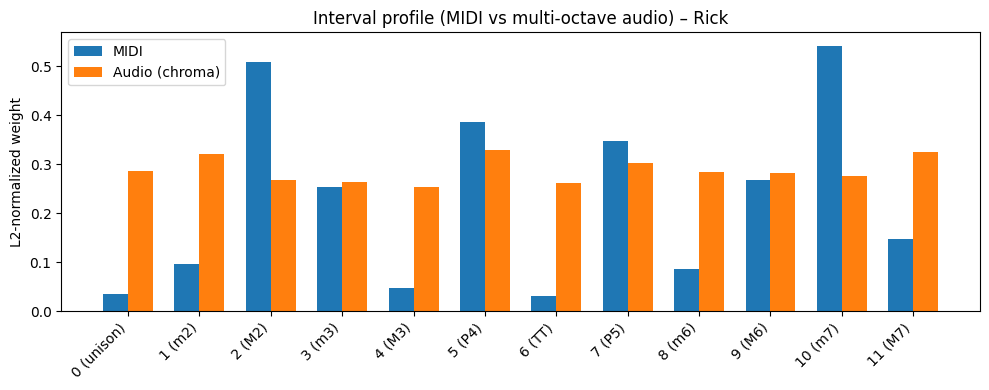

In [82]:
plot_interval_profiles(
    midi_metrics_rick["interval_vec"],
    audio_multi_metrics_rick["interval_vec"],
    title="Interval profile (MIDI vs multi-octave audio) – Rick"
)


In [83]:
def compare_midi_audio_three(midi_path, audio_path, label="piece"):
    """
    Compare MIDI vs:
      - Audio12   : beat-sync harmonic chroma (12-node)
      - AudioMulti: multi-octave (pc, band) audio network
    Prints cosine similarities of interval profiles and a metrics table.
    """
    print(f"=== {label} ===")

    midi_metrics       = compute_midi_network_metrics(midi_path)
    audio12_metrics    = compute_audio_network_metrics(audio_path)
    audio_multi_metrics = compute_audio_multiband_network_metrics(audio_path)

    compare_keys = [
        "n_nodes",
        "n_edges",
        "density",
        "r_real",
        "r_null",
        "rho_norm",
        "mean_entropy",
        "eff_unweighted",
        "eff_weighted",
    ]

    rows = []
    for domain, metrics in [
        ("MIDI", midi_metrics),
        ("Audio12", audio12_metrics),
        ("AudioMulti", audio_multi_metrics),
    ]:
        row = {"piece": label, "domain": domain}
        for k in compare_keys:
            row[k] = metrics[k]
        rows.append(row)

    df = pd.DataFrame(rows).set_index(["piece", "domain"])

    # Cosine similarities of interval profiles
    iv_midi   = midi_metrics["interval_vec"]
    iv_a12    = audio12_metrics["interval_vec"]
    iv_amulti = audio_multi_metrics["interval_vec"]

    cos_a12 = float(
        np.dot(iv_midi, iv_a12) /
        (np.linalg.norm(iv_midi) * np.linalg.norm(iv_a12) + EPS)
    )
    cos_amulti = float(
        np.dot(iv_midi, iv_amulti) /
        (np.linalg.norm(iv_midi) * np.linalg.norm(iv_amulti) + EPS)
    )

    print("Cosine similarity (MIDI vs Audio12):   ", cos_a12)
    print("Cosine similarity (MIDI vs AudioMulti):", cos_amulti)
    display(df)

    # Plots: interval profiles & graphs
    plot_interval_profiles(
        iv_midi, iv_a12,
        title=f"Interval profile – MIDI vs Audio12 – {label}"
    )
    plot_interval_profiles(
        iv_midi, iv_amulti,
        title=f"Interval profile – MIDI vs AudioMulti – {label}"
    )

    plot_midi_graph(midi_metrics["graph"], title=f"MIDI note network – {label}")
    plot_pitchclass_graph(audio12_metrics["graph"], title=f"Audio chroma (12-node) – {label}")
    plot_multiband_audio_graph(audio_multi_metrics["graph"], title=f"Audio multi-octave – {label}")

    return {
        "midi": midi_metrics,
        "audio12": audio12_metrics,
        "audio_multi": audio_multi_metrics,
        "df": df,
        "cos_a12": cos_a12,
        "cos_amulti": cos_amulti,
    }


=== Never Gonna Give You Up ===
Cosine similarity (MIDI vs Audio12):    0.9151806830258301
Cosine similarity (MIDI vs AudioMulti): 0.79268892216929


n_nodes  n_edges   density    r_real  \
piece                   domain                                             
Never Gonna Give You Up MIDI             41      228  0.139024  0.743737   
                        Audio12          12       95  0.719697  0.792564   
                        AudioMulti       54     1447  0.505590  0.596958   

                                      r_null  rho_norm  mean_entropy  \
piece                   domain                                         
Never Gonna Give You Up MIDI        0.303411  0.632117      0.615626   
                        Audio12     0.375734  0.667712      0.886146   
                        AudioMulti  0.393650  0.335298      0.934417   

                                    eff_unweighted  eff_weighted  
piece                   domain                                    
Never Gonna Give You Up MIDI              0.417628      3.934737  
                        Audio12           0.857323      9.689054  
                        AudioMulti        0.751689      3.607990

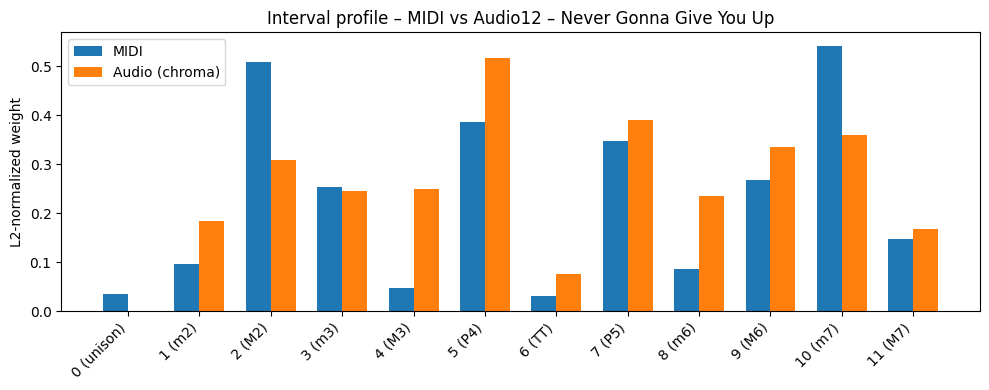

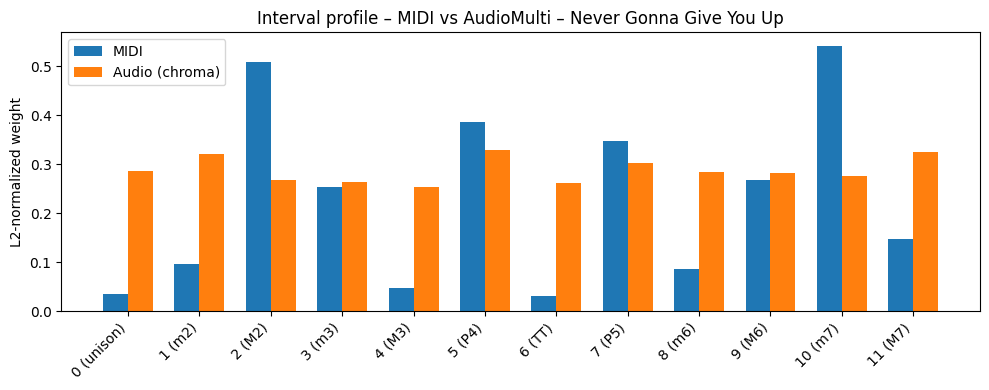

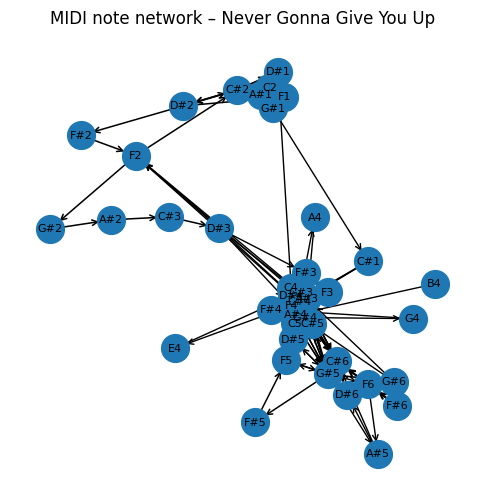

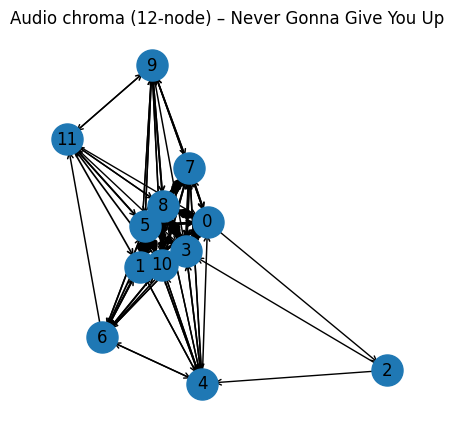

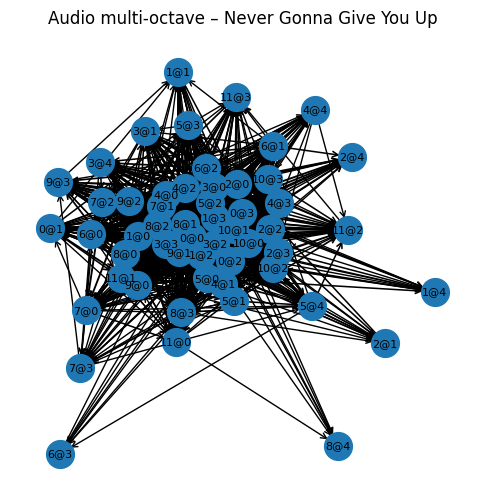

In [84]:
rick_three = compare_midi_audio_three(
    MIDI_PATH_RICK,
    AUDIO_PATH_RICK,
    label="Never Gonna Give You Up"
)


=== Für Elise ===


c:\Users\emanu\miniconda3\envs\BasicPy\Lib\site-packages\pretty_midi\pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Cosine similarity (MIDI vs Audio12):    0.8503699733010706
Cosine similarity (MIDI vs AudioMulti): 0.9224128616209534


n_nodes  n_edges   density    r_real    r_null  \
piece     domain                                                       
Für Elise MIDI             56      269  0.087338  0.417123  0.247038   
          Audio12          12       73  0.553030  0.742857  0.376714   
          AudioMulti       46      649  0.313527  0.662485  0.314934   

                      rho_norm  mean_entropy  eff_unweighted  eff_weighted  
piece     domain                                                            
Für Elise MIDI        0.225887      0.534693        0.344194      2.523089  
          Audio12     0.587440      0.882088        0.775253      7.842128  
          AudioMulti  0.507325      0.912563        0.639010      3.187015

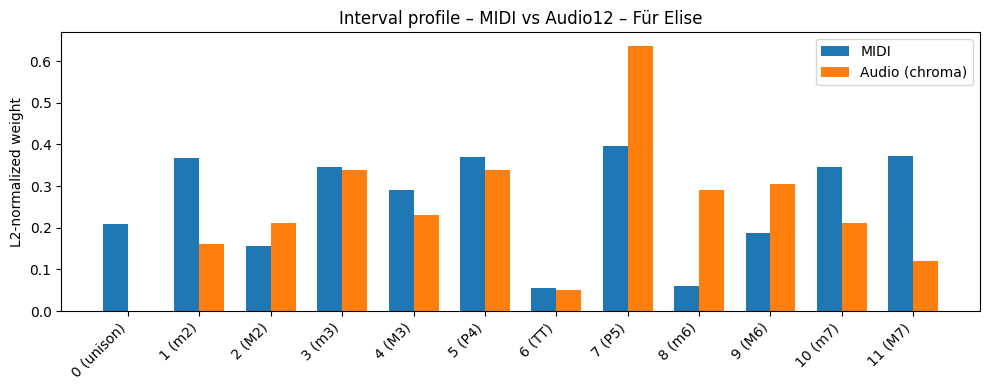

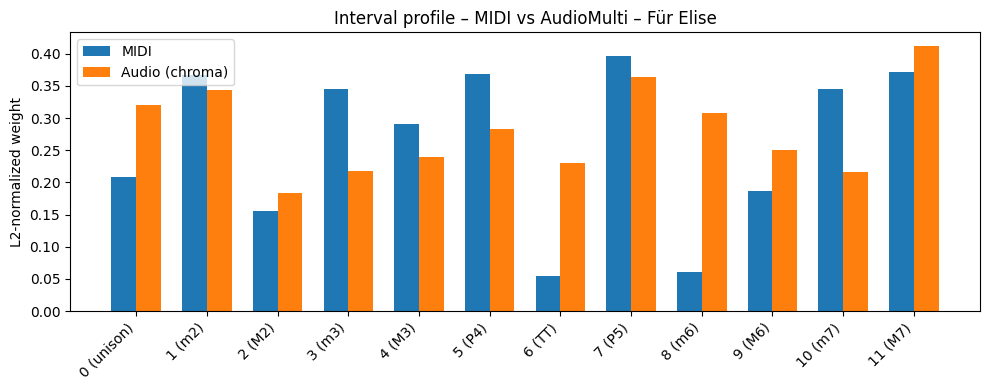

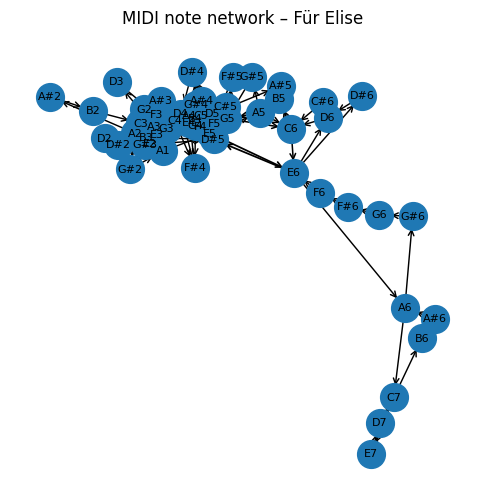

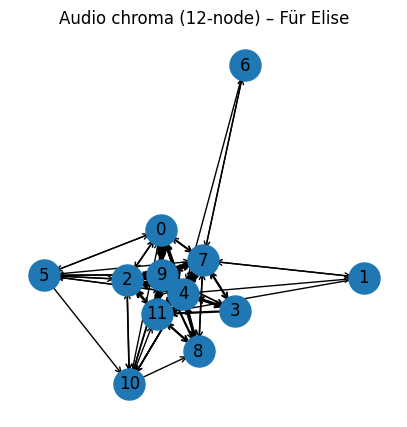

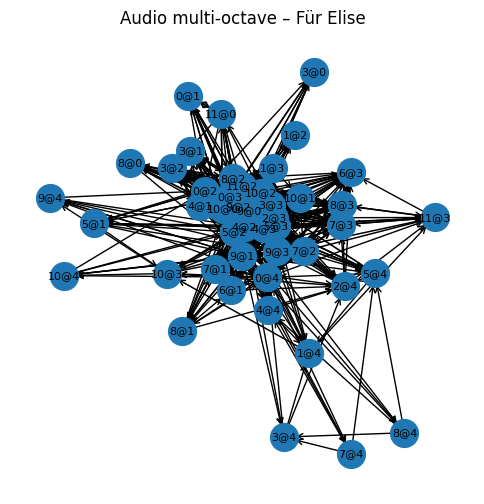

In [85]:
fe_three = compare_midi_audio_three(
    MIDI_PATH_FE,
    AUDIO_PATH_FE,
    label="Für Elise"
)

In [86]:
# --- helper to map CQT bin index -> (pitch class, octave band) ---

def _bin_to_pc_band(idx, bins_per_octave=12):
    pc = int(idx % bins_per_octave)
    band = int(idx // bins_per_octave)
    return pc, band


In [87]:
# ===========================
# AUDIO MULTI-OCTAVE 2.0
# (harmonic + note events)
# ===========================

AM2_REL_THRESH_FRAME = 0.4   # relative to frame max (within frame)
AM2_MIN_GLOBAL_ENERGY = 0.02 # relative to global max (very small)
AM2_TOP_K_PER_FRAME = 4      # max (pc,band) bins per frame
AM2_MIN_FRAMES_NOTE = 3      # min contiguous frames for a note event
AM2_N_OCTAVES = 5            # number of octaves in CQT
AM2_BASE_NOTE = "C2"         # CQT lowest note


def multi_octave_chord_sequence_events(
        y,
        sr=SR,
        rel_thresh_frame=AM2_REL_THRESH_FRAME,
        min_global_energy=AM2_MIN_GLOBAL_ENERGY,
        top_k_per_frame=AM2_TOP_K_PER_FRAME,
        min_frames_note=AM2_MIN_FRAMES_NOTE,
        n_octaves=AM2_N_OCTAVES,
        base_note=AM2_BASE_NOTE,
        hop_length=HOP_LENGTH,
):
    """
    AudioMulti 2.0:
    From audio -> harmonic multi-octave CQT -> per-frame active bins
    -> harmonic suppression -> note events (min duration)
    -> chord sequence at note onset times.

    Nodes are (pc, band) tuples:
        pc   ∈ {0..11}
        band ∈ {0..n_octaves-1}

    Returns: list of chords, each chord a tuple of (pc, band).
    """

    # 1) HPSS: harmonic component only
    y_harm, y_perc = librosa.effects.hpss(y)

    # 2) Multi-octave CQT
    C = librosa.cqt(
        y_harm,
        sr=sr,
        hop_length=hop_length,
        fmin=librosa.note_to_hz(base_note),
        n_bins=n_octaves * 12,
        bins_per_octave=12,
    )
    C_mag = np.abs(C)  # (F, T)

    F, T = C_mag.shape
    if T == 0 or F == 0:
        return []

    global_max = C_mag.max()
    if global_max <= 0:
        return []

    # 3) Per-frame active bins (before events)
    #    This is a boolean mask: active_bins[f,t]
    active_bins = np.zeros_like(C_mag, dtype=bool)

    for t in range(T):
        frame = C_mag[:, t]
        fmax = frame.max()
        if fmax <= 0:
            continue

        # Skip frames with very low energy globally
        if fmax < min_global_energy * global_max:
            continue

        # relative to frame max
        mask = frame >= (rel_thresh_frame * fmax)
        idxs = np.where(mask)[0]
        if idxs.size == 0:
            continue

        # keep at most top_k_per_frame bins
        if idxs.size > top_k_per_frame:
            idxs = idxs[np.argsort(frame[idxs])[::-1][:top_k_per_frame]]

        # harmonic suppression: for each pitch class, keep only lowest band
        # among selected idxs
        # build mapping pc -> list of (band, idx, magnitude)
        pc_map = {}
        for idx in idxs:
            pc, band = _bin_to_pc_band(idx, bins_per_octave=12)
            pc_map.setdefault(pc, []).append((band, idx, frame[idx]))

        keep_idxs = []
        for pc, entries in pc_map.items():
            # entries: list of (band, idx, mag)
            # sort by band ascending (low register first)
            entries_sorted = sorted(entries, key=lambda x: x[0])
            # always keep the lowest band entry
            band0, idx0, mag0 = entries_sorted[0]
            keep_idxs.append(idx0)

            # optionally keep higher bands if they are strong enough
            # compared to the lowest one (e.g. >= 0.8 of mag0)
            for band_k, idx_k, mag_k in entries_sorted[1:]:
                if mag_k >= 0.8 * mag0:
                    keep_idxs.append(idx_k)
                # else: treat as harmonic overtone, discard

        # mark bins as active
        for idx in keep_idxs:
            active_bins[idx, t] = True

    # 4) Note-event detection for each bin (continuous active segments)
    #    events: list of (start_frame, (pc, band))
    events = []
    for f_idx in range(F):
        pc, band = _bin_to_pc_band(f_idx, bins_per_octave=12)
        is_on = False
        start_t = 0
        for t in range(T):
            a = active_bins[f_idx, t]
            if a and not is_on:
                is_on = True
                start_t = t
            elif not a and is_on:
                # note ended at t-1
                length = t - start_t
                if length >= min_frames_note:
                    events.append((start_t, (pc, band)))
                is_on = False
        # if still on at end
        if is_on:
            length = T - start_t
            if length >= min_frames_note:
                events.append((start_t, (pc, band)))

    if not events:
        return []

    # 5) Group events by start_frame -> chords
    events.sort(key=lambda x: x[0])  # sort by start frame
    time_to_nodes = {}
    for frame_idx, node in events:
        time_to_nodes.setdefault(frame_idx, []).append(node)

    chords = []
    for frame_idx in sorted(time_to_nodes.keys()):
        chord_nodes = tuple(sorted(set(time_to_nodes[frame_idx])))
        if len(chord_nodes) > 0:
            chords.append(chord_nodes)

    # 6) Compress consecutive duplicate chords
    final_chords = []
    prev = None
    for c in chords:
        if c != prev:
            final_chords.append(c)
            prev = c

    return final_chords


In [88]:
def compute_audio_multiband2_network_metrics(audio_path):
    """
    AudioMulti 2.0 network:
    - Uses multi_octave_chord_sequence_events (harmonic, note events)
    - Nodes = (pc, band)
    - Edges = transitions between chords at note onset times
    """
    y, sr = librosa.load(audio_path, sr=SR, mono=True)

    chords = multi_octave_chord_sequence_events(y, sr=sr)
    G = build_chord_transition_graph(chords)

    metrics = {}
    metrics["n_nodes"] = G.number_of_nodes()
    metrics["n_edges"] = G.number_of_edges()
    metrics["density"] = nx.density(G)

    r_real, r_null, rho = normalized_weighted_reciprocity(G)
    metrics["r_real"] = r_real
    metrics["r_null"] = r_null
    metrics["rho_norm"] = rho

    metrics["mean_entropy"] = mean_node_entropy(G)
    metrics["eff_unweighted"] = global_efficiency_unweighted(G)
    metrics["eff_weighted"] = global_efficiency_weighted(G)

    metrics["interval_vec"] = interval_embedding_12d(G)
    metrics["graph"] = G
    return metrics


In [89]:
def compare_midi_audio_four(midi_path, audio_path, label="piece"):
    """
    Compare MIDI vs:
      - Audio12      : beat-sync harmonic chroma (12-node)
      - AudioMulti   : multi-octave beat-sync per-beat (old v1)
      - AudioMulti2  : multi-octave note events (v2)
    """
    print(f"=== {label} ===")

    midi_metrics        = compute_midi_network_metrics(midi_path)
    audio12_metrics     = compute_audio_network_metrics(audio_path)
    audio_multi_metrics = compute_audio_multiband_network_metrics(audio_path)
    audio_m2_metrics    = compute_audio_multiband2_network_metrics(audio_path)

    compare_keys = [
        "n_nodes",
        "n_edges",
        "density",
        "r_real",
        "r_null",
        "rho_norm",
        "mean_entropy",
        "eff_unweighted",
        "eff_weighted",
    ]

    rows = []
    for domain, metrics in [
        ("MIDI",        midi_metrics),
        ("Audio12",     audio12_metrics),
        ("AudioMulti",  audio_multi_metrics),
        ("AudioMulti2", audio_m2_metrics),
    ]:
        row = {"piece": label, "domain": domain}
        for k in compare_keys:
            row[k] = metrics[k]
        rows.append(row)

    df = pd.DataFrame(rows).set_index(["piece", "domain"])

    # Cosine similarities
    iv_midi   = midi_metrics["interval_vec"]
    iv_a12    = audio12_metrics["interval_vec"]
    iv_amulti = audio_multi_metrics["interval_vec"]
    iv_am2    = audio_m2_metrics["interval_vec"]

    def cos(a, b):
        return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + EPS))

    cos_a12   = cos(iv_midi, iv_a12)
    cos_amulti = cos(iv_midi, iv_amulti)
    cos_am2   = cos(iv_midi, iv_am2)

    print("Cosine (MIDI vs Audio12):    ", cos_a12)
    print("Cosine (MIDI vs AudioMulti): ", cos_amulti)
    print("Cosine (MIDI vs AudioMulti2):", cos_am2)
    display(df)

    # Interval plots (you can comment some out if too many)
    plot_interval_profiles(iv_midi, iv_a12,
                           title=f"Interval profile – MIDI vs Audio12 – {label}")
    plot_interval_profiles(iv_midi, iv_amulti,
                           title=f"Interval profile – MIDI vs AudioMulti – {label}")
    plot_interval_profiles(iv_midi, iv_am2,
                           title=f"Interval profile – MIDI vs AudioMulti2 – {label}")

    # Graph plots
    plot_midi_graph(midi_metrics["graph"], title=f"MIDI note network – {label}")
    plot_pitchclass_graph(audio12_metrics["graph"], title=f"Audio chroma (12-node) – {label}")
    plot_multiband_audio_graph(audio_multi_metrics["graph"], title=f"Audio multi-octave v1 – {label}")
    plot_multiband_audio_graph(audio_m2_metrics["graph"], title=f"Audio multi-octave v2 – {label}")

    return {
        "midi": midi_metrics,
        "audio12": audio12_metrics,
        "audio_multi": audio_multi_metrics,
        "audio_multi2": audio_m2_metrics,
        "df": df,
        "cos_a12": cos_a12,
        "cos_amulti": cos_amulti,
        "cos_am2": cos_am2,
    }


=== Never Gonna Give You Up ===
Cosine (MIDI vs Audio12):     0.9151806830258301
Cosine (MIDI vs AudioMulti):  0.79268892216929
Cosine (MIDI vs AudioMulti2): 0.6856921732673528


n_nodes  n_edges   density    r_real  \
piece                   domain                                              
Never Gonna Give You Up MIDI              41      228  0.139024  0.743737   
                        Audio12           12       95  0.719697  0.792564   
                        AudioMulti        54     1447  0.505590  0.596958   
                        AudioMulti2       60     1863  0.526271  0.585108   

                                       r_null  rho_norm  mean_entropy  \
piece                   domain                                          
Never Gonna Give You Up MIDI         0.313281  0.626830      0.615626   
                        Audio12      0.388258  0.660909      0.886146   
                        AudioMulti   0.400532  0.327667      0.934417   
                        AudioMulti2  0.338460  0.372840      0.866195   

                                     eff_unweighted  eff_weighted  
piece                   domain                                     
Never Gonna Give You Up MIDI               0.417628      3.934737  
                        Audio12            0.857323      9.689054  
                        AudioMulti         0.751689      3.607990  
                        AudioMulti2        0.762853      6.366506

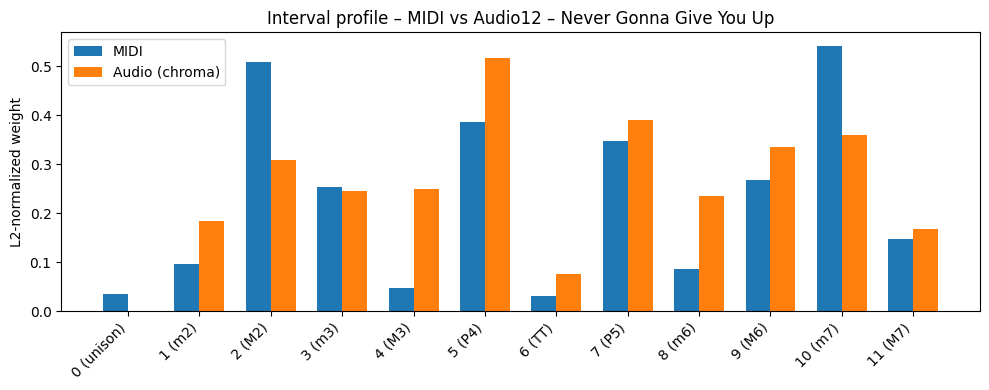

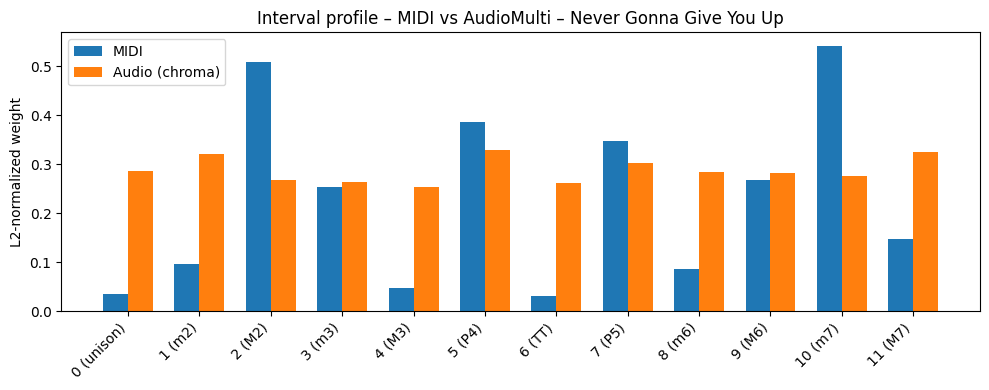

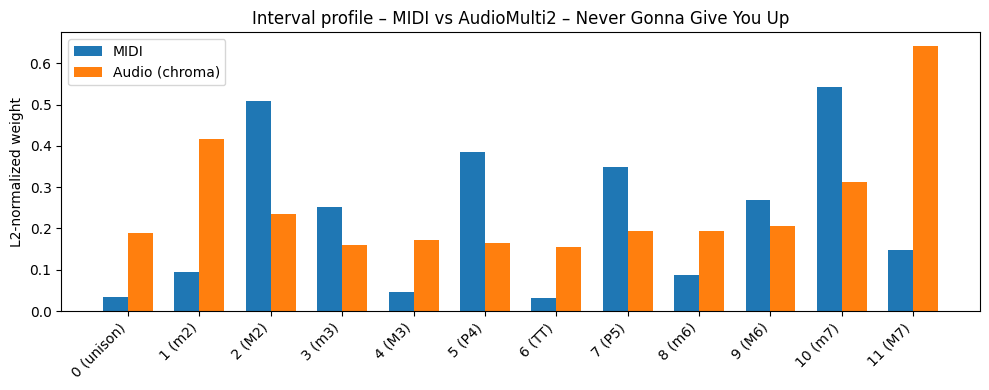

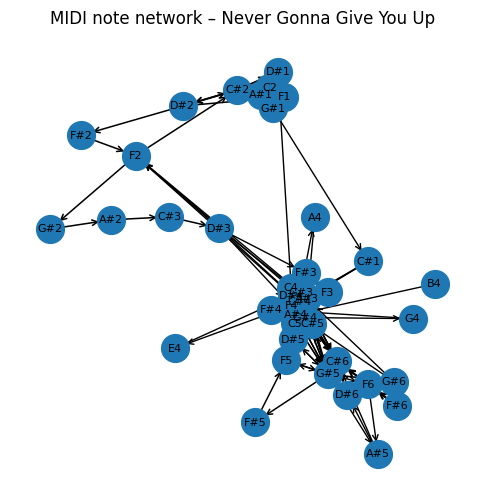

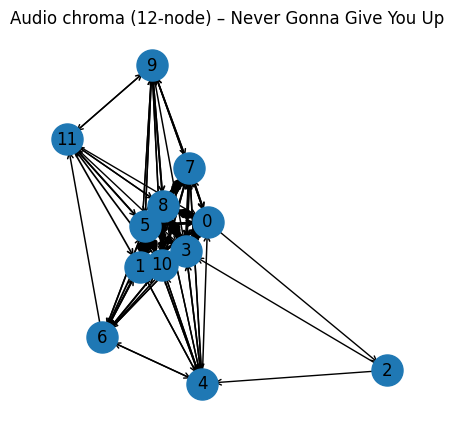

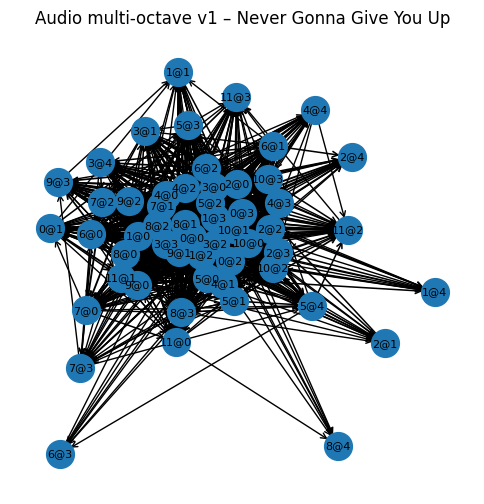

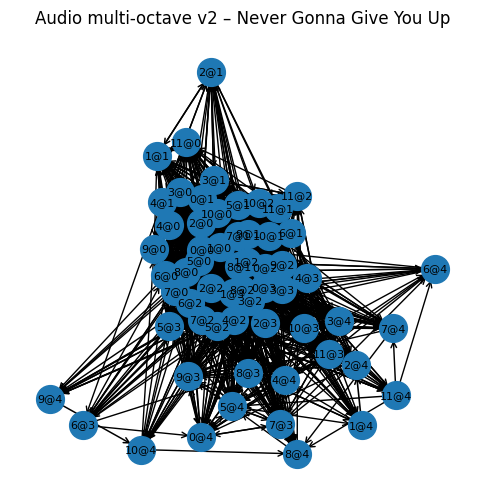

In [90]:
rick_four = compare_midi_audio_four(
    MIDI_PATH_RICK,
    AUDIO_PATH_RICK,
    label="Never Gonna Give You Up"
)


=== Für Elise ===


c:\Users\emanu\miniconda3\envs\BasicPy\Lib\site-packages\pretty_midi\pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Cosine (MIDI vs Audio12):     0.8503699733010706
Cosine (MIDI vs AudioMulti):  0.9224128616209534
Cosine (MIDI vs AudioMulti2): 0.880802116158587


n_nodes  n_edges   density    r_real    r_null  \
piece     domain                                                        
Für Elise MIDI              56      269  0.087338  0.417123  0.234644   
          Audio12           12       73  0.553030  0.742857  0.372000   
          AudioMulti        46      649  0.313527  0.662485  0.321266   
          AudioMulti2       54      757  0.264500  0.565971  0.303732   

                       rho_norm  mean_entropy  eff_unweighted  eff_weighted  
piece     domain                                                             
Für Elise MIDI         0.238424      0.534693        0.344194      2.523089  
          Audio12      0.590537      0.882088        0.775253      7.842128  
          AudioMulti   0.502728      0.912563        0.639010      3.187015  
          AudioMulti2  0.376635      0.831171        0.601037      2.988522

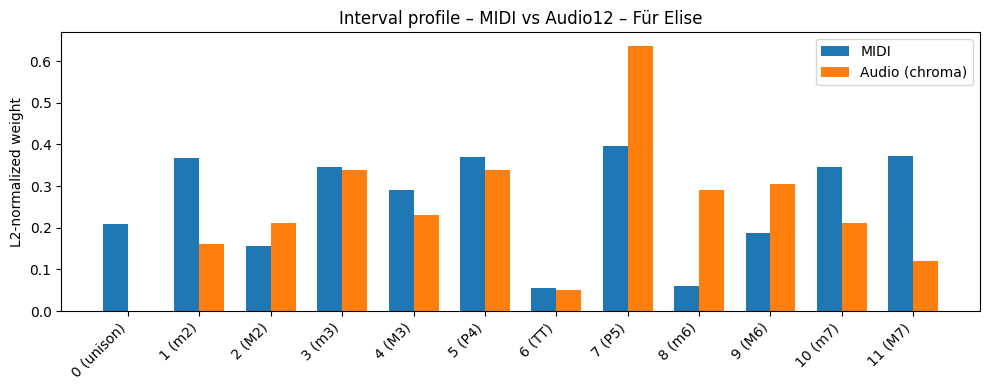

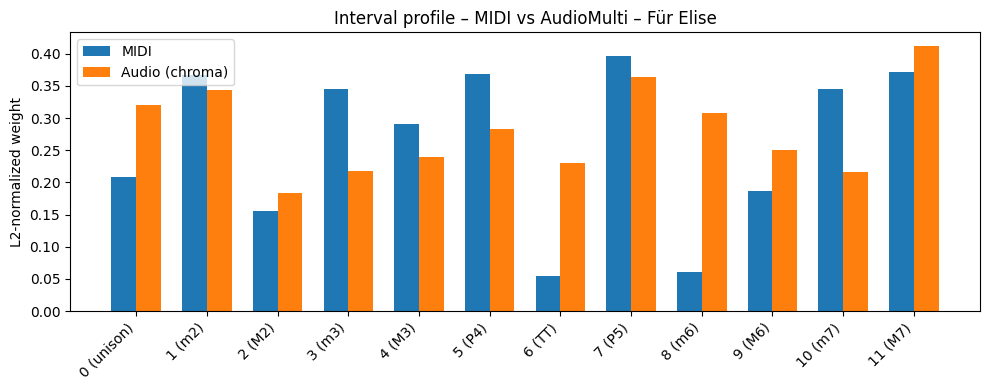

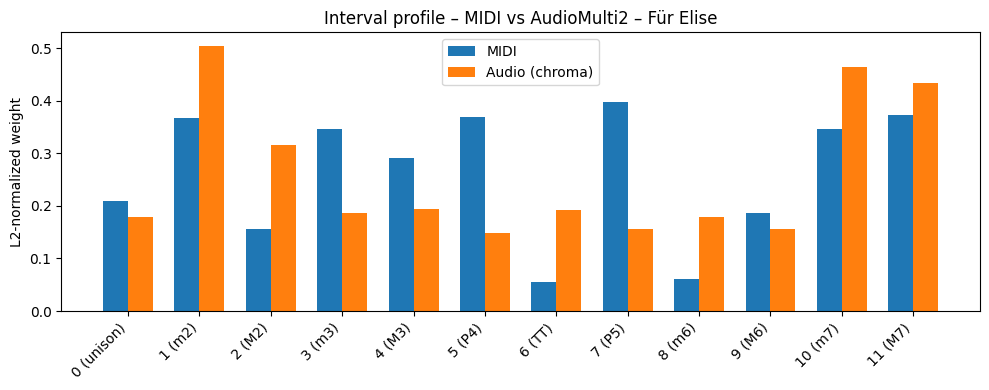

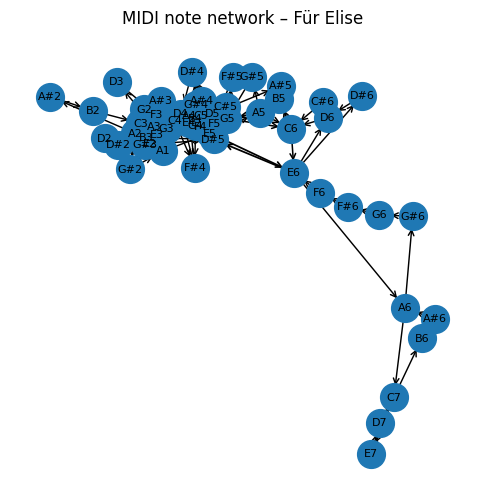

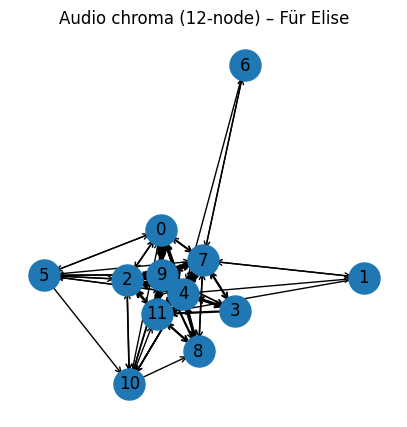

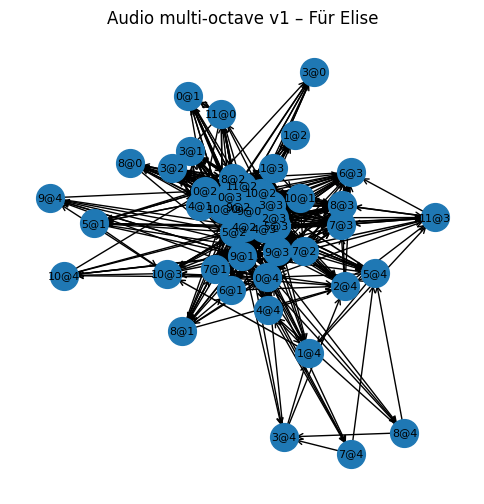

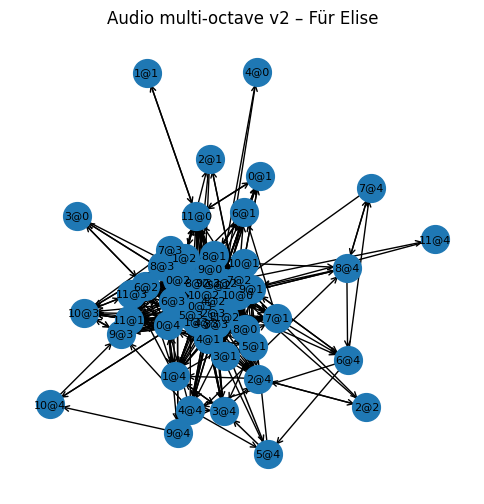

In [91]:
fe_four = compare_midi_audio_four(
    MIDI_PATH_FE,
    AUDIO_PATH_FE,
    label="Für Elise"
)


In [92]:
# === AudioMulti-Compact config ===
AMC_N_OCTAVES = 5          # CQT octaves
AMC_BASE_NOTE = "C2"       # CQT fmin
AMC_REL_THRESH = 0.4       # relative to per-beat max energy
AMC_MIN_GLOBAL = 0.02      # minimum energy relative to global max
AMC_ALPHA_BAND = 0.6       # keep secondary band if >= 60% of main band
AMC_MAX_NODES_PER_BEAT = 6 # cap on active (pc, band) per beat
AMC_N_BANDS = 3            # low/mid/high coarse bands

In [93]:
def _cqt_bin_to_band_pc(idx, n_octaves=AMC_N_OCTAVES, n_bands=AMC_N_BANDS):
    """
    Map CQT bin index -> (band, pitch_class)
    We have 12 bins per octave. We group octaves into n_bands coarse bands.
    For AMC_N_OCTAVES=5, AMC_N_BANDS=3, a simple mapping is:
      octaves 0-1 -> band 0 (low)
      octaves 2-3 -> band 1 (mid)
      octave  4   -> band 2 (high)
    """
    pc = int(idx % 12)
    octave = int(idx // 12)  # 0..n_octaves-1

    # coarse band mapping
    if octave <= 1:
        band = 0
    elif octave <= 3:
        band = 1
    else:
        band = 2
    return band, pc


In [94]:
def multi_octave_chord_sequence_compact(
        y,
        sr=SR,
        n_octaves=AMC_N_OCTAVES,
        base_note=AMC_BASE_NOTE,
        rel_thresh=AMC_REL_THRESH,
        min_global=AMC_MIN_GLOBAL,
        alpha_band=AMC_ALPHA_BAND,
        max_nodes_per_beat=AMC_MAX_NODES_PER_BEAT,
        n_bands=AMC_N_BANDS,
        hop_length=HOP_LENGTH,
):
    """
    AudioMulti-Compact:
    - Harmonic HPSS
    - Multi-octave CQT
    - Beat-synchronous aggregation
    - Coarse bands (low/mid/high) x pitch class
    - Harmonic compression (dominant band per pc, optional secondary)
    - Global cap on nodes per beat

    Returns: list of chords; each chord is a tuple of (pc, band).
    """
    # 1) HPSS: keep harmonic component
    y_harm, y_perc = librosa.effects.hpss(y)

    # 2) Multi-octave CQT
    C = librosa.cqt(
        y_harm,
        sr=sr,
        hop_length=hop_length,
        fmin=librosa.note_to_hz(base_note),
        n_bins=n_octaves * 12,
        bins_per_octave=12,
    )
    C_mag = np.abs(C)  # (F, T_frames)
    F, T = C_mag.shape
    if F == 0 or T == 0:
        return []

    global_max = C_mag.max()
    if global_max <= 0:
        return []

    # 3) Beat tracking & beat-sync
    onset_env = librosa.onset.onset_strength(y=y_harm, sr=sr, hop_length=hop_length)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    if beats.size > 0:
        C_sync = librosa.util.sync(C_mag, beats, aggregate=np.median)  # (F, T_beats)
    else:
        C_sync = C_mag  # fallback
    F, T = C_sync.shape

    # 4) Precompute band-pc mapping
    band_pc_indices = [[[] for _ in range(12)] for _ in range(n_bands)]
    for f_idx in range(F):
        band, pc = _cqt_bin_to_band_pc(f_idx, n_octaves=n_octaves, n_bands=n_bands)
        if 0 <= band < n_bands:
            band_pc_indices[band][pc].append(f_idx)

    chords = []
    prev_chord = None

    # 5) Process each beat
    for t in range(T):
        frame = C_sync[:, t]
        frame_max = frame.max()
        if frame_max < min_global * global_max:
            # too quiet: treat as silence
            chord = ()
        else:
            # compute band x pc energies
            E = np.zeros((n_bands, 12), dtype=float)
            for band in range(n_bands):
                for pc in range(12):
                    idxs = band_pc_indices[band][pc]
                    if idxs:
                        E[band, pc] = frame[idxs].sum()

            # candidates: (pc, band, energy)
            candidates = []
            for pc in range(12):
                band_energies = E[:, pc]
                pc_max = band_energies.max()
                if pc_max < rel_thresh * frame_max:
                    continue  # pc too weak on this beat

                main_band = int(np.argmax(band_energies))
                main_energy = band_energies[main_band]
                candidates.append((pc, main_band, main_energy))

                # optional second band if strong enough
                for b in range(n_bands):
                    if b == main_band:
                        continue
                    e_b = band_energies[b]
                    if e_b >= alpha_band * main_energy:
                        candidates.append((pc, b, e_b))

            if not candidates:
                chord = ()
            else:
                # sort by energy descending, take top max_nodes_per_beat
                candidates.sort(key=lambda x: x[2], reverse=True)
                nodes = []
                for pc, band, energy in candidates[:max_nodes_per_beat]:
                    nodes.append((pc, band))
                # deduplicate & sort
                chord = tuple(sorted(set(nodes)))

        if chord != prev_chord and len(chord) > 0:
            chords.append(chord)
            prev_chord = chord

    return chords


In [95]:
def compute_audio_multiband_compact_network_metrics(audio_path):
    """
    AudioMulti-Compact network:
    - Nodes = (pc, band) tuples (36 max)
    - Edges = transitions between beat-level chords
    """
    y, sr = librosa.load(audio_path, sr=SR, mono=True)

    chords = multi_octave_chord_sequence_compact(y, sr=sr)
    G = build_chord_transition_graph(chords)

    metrics = {}
    metrics["n_nodes"] = G.number_of_nodes()
    metrics["n_edges"] = G.number_of_edges()
    metrics["density"] = nx.density(G)

    r_real, r_null, rho = normalized_weighted_reciprocity(G)
    metrics["r_real"] = r_real
    metrics["r_null"] = r_null
    metrics["rho_norm"] = rho

    metrics["mean_entropy"] = mean_node_entropy(G)
    metrics["eff_unweighted"] = global_efficiency_unweighted(G)
    metrics["eff_weighted"] = global_efficiency_weighted(G)

    metrics["interval_vec"] = interval_embedding_12d(G)
    metrics["graph"] = G
    return metrics

In [96]:

def compare_midi_vs_amc(midi_path, audio_path, label="piece"):
    """
    Compare MIDI network vs AudioMulti-Compact network for one piece.
    Shows:
      - cosine similarity of interval profiles
      - table of graph metrics (MIDI vs AudioMultiCompact)
      - interval profile plot
      - MIDI graph + AudioMultiCompact graph
    """
    print(f"=== {label} ===")

    midi_metrics = compute_midi_network_metrics(midi_path)
    amc_metrics  = compute_audio_multiband_compact_network_metrics(audio_path)

    compare_keys = [
        "n_nodes",
        "n_edges",
        "density",
        "r_real",
        "r_null",
        "rho_norm",
        "mean_entropy",
        "eff_unweighted",
        "eff_weighted",
    ]

    rows = []
    for domain, metrics in [("MIDI", midi_metrics), ("AudioMultiCompact", amc_metrics)]:
        row = {"piece": label, "domain": domain}
        for k in compare_keys:
            row[k] = metrics[k]
        rows.append(row)

    df = pd.DataFrame(rows).set_index(["piece", "domain"])

    # cosine similarity of interval profiles
    iv_midi = midi_metrics["interval_vec"]
    iv_amc  = amc_metrics["interval_vec"]

    cosine_sim = float(
        np.dot(iv_midi, iv_amc) /
        (np.linalg.norm(iv_midi) * np.linalg.norm(iv_amc) + EPS)
    )

    print("Cosine similarity (MIDI vs AudioMultiCompact):", cosine_sim)
    display(df)

    # plots
    plot_interval_profiles(
        iv_midi,
        iv_amc,
        title=f"Interval profile – MIDI vs AudioMultiCompact – {label}"
    )

    plot_midi_graph(midi_metrics["graph"], title=f"MIDI note network – {label}")
    plot_multiband_audio_graph(
        amc_metrics["graph"],
        title=f"Audio multi-octave compact – {label}"
    )

    return {
        "midi": midi_metrics,
        "audio_multicompact": amc_metrics,
        "df": df,
        "cosine": cosine_sim,
    }


=== Never Gonna Give You Up ===
Cosine similarity (MIDI vs AudioMultiCompact): 0.8000274354579776


n_nodes  n_edges   density  \
piece                   domain                                          
Never Gonna Give You Up MIDI                    41      228  0.139024   
                        AudioMultiCompact       30      647  0.743678   

                                             r_real    r_null  rho_norm  \
piece                   domain                                            
Never Gonna Give You Up MIDI               0.743737  0.312436  0.627288   
                        AudioMultiCompact  0.816708  0.523385  0.615430   

                                           mean_entropy  eff_unweighted  \
piece                   domain                                            
Never Gonna Give You Up MIDI                   0.615626        0.417628   
                        AudioMultiCompact      0.943313        0.871264   

                                           eff_weighted  
piece                   domain                           
Never Gonna Give You Up MIDI                   3.934737  
                        AudioMultiCompact     16.579614

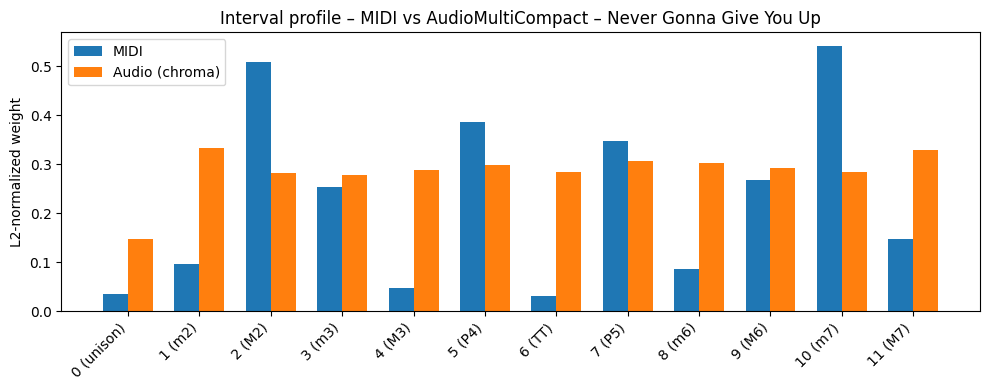

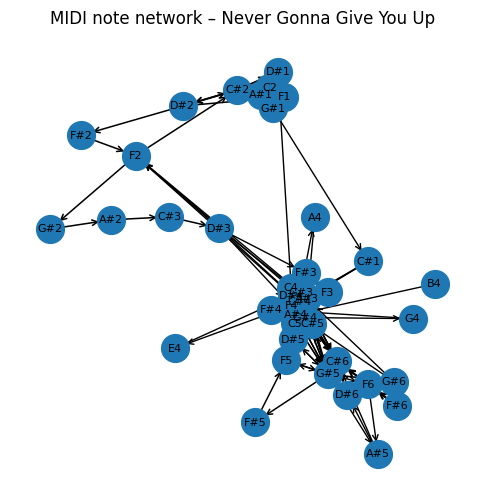

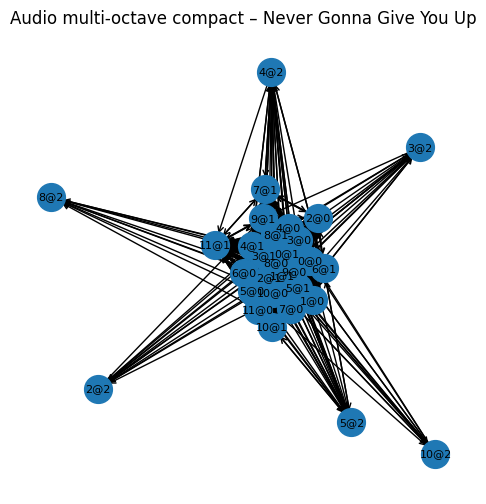

In [97]:
# Never Gonna Give You Up
rick_amc = compare_midi_vs_amc(
    MIDI_PATH_RICK,
    AUDIO_PATH_RICK,
    label="Never Gonna Give You Up"
)

=== Für Elise ===


c:\Users\emanu\miniconda3\envs\BasicPy\Lib\site-packages\pretty_midi\pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Cosine similarity (MIDI vs AudioMultiCompact): 0.9138046272760838


n_nodes  n_edges   density    r_real    r_null  \
piece     domain                                                              
Für Elise MIDI                    56      269  0.087338  0.417123  0.228920   
          AudioMultiCompact       34      546  0.486631  0.824012  0.316654   

                             rho_norm  mean_entropy  eff_unweighted  \
piece     domain                                                      
Für Elise MIDI               0.244077      0.534693        0.344194   
          AudioMultiCompact  0.742461      0.908704        0.735294   

                             eff_weighted  
piece     domain                           
Für Elise MIDI                   2.523089  
          AudioMultiCompact      9.654222

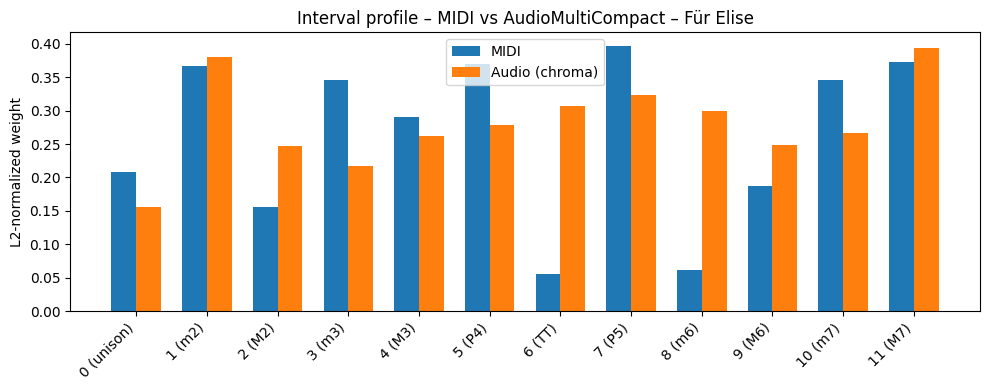

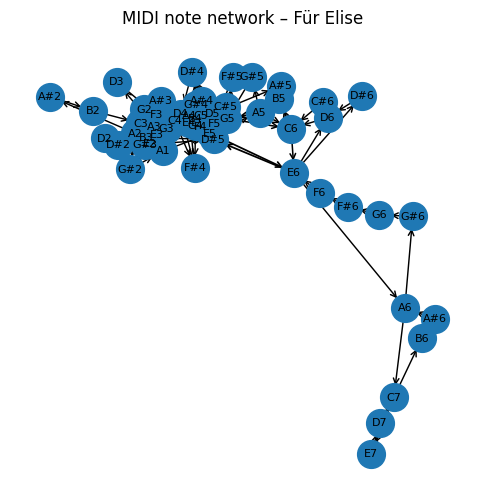

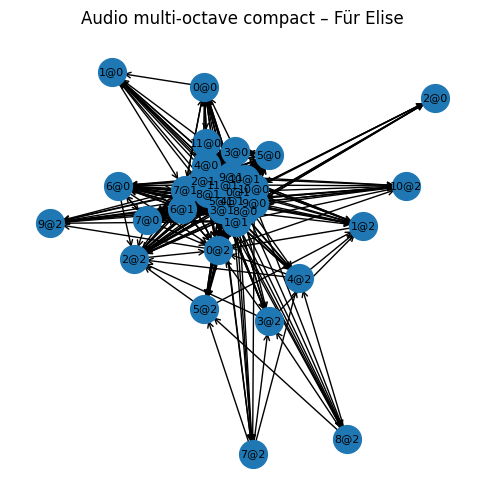

In [98]:
# Für Elise
fe_amc = compare_midi_vs_amc(
    MIDI_PATH_FE,
    AUDIO_PATH_FE,
    label="Für Elise"
)


In [99]:
# === AudioMulti-Compact v2 extra config ===
AMC_BASS_ATTENUATION = 0.7     # scale low-band energy so bass doesn't dominate
AMC_MEDIAN_FACTOR    = 1.5     # adaptive threshold: median * factor
AMC_MIN_EDGE_ABS     = 2.0     # prune edges with weight < this
AMC_MIN_EDGE_REL     = 0.02    # or < this fraction of node's outgoing strength


In [100]:
def prune_graph_by_weight(G, min_abs=AMC_MIN_EDGE_ABS, min_rel=AMC_MIN_EDGE_REL):
    """
    Prune weak edges:
      - remove edges with weight < min_abs
      - or weight < min_rel * (sum of outgoing weights of source)
    Also removes isolated nodes after pruning.
    Returns a NEW graph H.
    """
    H = G.copy()
    for u in list(H.nodes()):
        out_edges = list(H.out_edges(u, data=True))
        if not out_edges:
            continue
        total_w = sum(d["weight"] for _, _, d in out_edges)
        for _, v, d in out_edges:
            w = d["weight"]
            if (w < min_abs) or (w < min_rel * total_w):
                if H.has_edge(u, v):
                    H.remove_edge(u, v)

    # remove isolated nodes
    isolates = list(nx.isolates(H))
    if isolates:
        H.remove_nodes_from(isolates)

    return H


In [101]:
def multi_octave_chord_sequence_compact_v2(
        y,
        sr=SR,
        n_octaves=AMC_N_OCTAVES,
        base_note=AMC_BASE_NOTE,
        rel_thresh=AMC_REL_THRESH,
        min_global=AMC_MIN_GLOBAL,
        alpha_band=AMC_ALPHA_BAND,
        max_nodes_per_beat=AMC_MAX_NODES_PER_BEAT,
        n_bands=AMC_N_BANDS,
        hop_length=HOP_LENGTH,
):
    """
    AudioMulti-Compact v2:
    - Same structure as v1, but with:
        * bass-band attenuation (bass vs mid/high separation)
        * adaptive per-beat threshold using median energy
    """
    # 1) HPSS: keep harmonic component
    y_harm, y_perc = librosa.effects.hpss(y)

    # 2) Multi-octave CQT
    C = librosa.cqt(
        y_harm,
        sr=sr,
        hop_length=hop_length,
        fmin=librosa.note_to_hz(base_note),
        n_bins=n_octaves * 12,
        bins_per_octave=12,
    )
    C_mag = np.abs(C)  # (F, T_frames)
    F, T = C_mag.shape
    if F == 0 or T == 0:
        return []

    global_max = C_mag.max()
    if global_max <= 0:
        return []

    # 3) Beat tracking & beat-sync
    onset_env = librosa.onset.onset_strength(y=y_harm, sr=sr, hop_length=hop_length)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    if beats.size > 0:
        C_sync = librosa.util.sync(C_mag, beats, aggregate=np.median)  # (F, T_beats)
    else:
        C_sync = C_mag
    F, T = C_sync.shape

    # 4) Precompute band-pc mapping
    band_pc_indices = [[[] for _ in range(12)] for _ in range(n_bands)]
    for f_idx in range(F):
        band, pc = _cqt_bin_to_band_pc(f_idx, n_octaves=n_octaves, n_bands=n_bands)
        if 0 <= band < n_bands:
            band_pc_indices[band][pc].append(f_idx)

    chords = []
    prev_chord = None

    # 5) Process each beat
    for t in range(T):
        frame = C_sync[:, t]
        frame_max = frame.max()
        if frame_max < min_global * global_max:
            chord = ()
        else:
            # compute band x pc energies
            E = np.zeros((n_bands, 12), dtype=float)
            for band in range(n_bands):
                for pc in range(12):
                    idxs = band_pc_indices[band][pc]
                    if idxs:
                        E[band, pc] = frame[idxs].sum()

            # --- bass attenuation (band 0) ---
            # reduce low-band energy a bit so it doesn't dominate sorting
            E[0, :] *= AMC_BASS_ATTENUATION

            # --- adaptive per-beat threshold ---
            nonzero = E[E > 0]
            if nonzero.size > 0:
                beat_median = np.median(nonzero)
                adaptive_thresh = max(rel_thresh * frame_max,
                                      AMC_MEDIAN_FACTOR * beat_median)
            else:
                adaptive_thresh = rel_thresh * frame_max

            # candidates: (pc, band, energy)
            candidates = []
            for pc in range(12):
                band_energies = E[:, pc]
                pc_max = band_energies.max()
                if pc_max < adaptive_thresh:
                    continue  # pc too weak on this beat

                main_band = int(np.argmax(band_energies))
                main_energy = band_energies[main_band]
                candidates.append((pc, main_band, main_energy))

                # optional second band if strong enough
                for b in range(n_bands):
                    if b == main_band:
                        continue
                    e_b = band_energies[b]
                    if e_b >= alpha_band * main_energy:
                        candidates.append((pc, b, e_b))

            if not candidates:
                chord = ()
            else:
                # sort by energy descending, take top max_nodes_per_beat
                candidates.sort(key=lambda x: x[2], reverse=True)
                nodes = []
                for pc, band, energy in candidates[:max_nodes_per_beat]:
                    nodes.append((pc, band))
                # deduplicate & sort
                chord = tuple(sorted(set(nodes)))

        if chord != prev_chord and len(chord) > 0:
            chords.append(chord)
            prev_chord = chord

    return chords


In [102]:
def compute_audio_multiband_compact_v2_network_metrics(audio_path):
    """
    AudioMulti-Compact v2 network:
    - Uses multi_octave_chord_sequence_compact_v2
    - Prunes weak edges by weight
    """
    y, sr = librosa.load(audio_path, sr=SR, mono=True)

    chords = multi_octave_chord_sequence_compact_v2(y, sr=sr)
    G_raw = build_chord_transition_graph(chords)
    G = prune_graph_by_weight(G_raw)  # apply edge pruning

    metrics = {}
    metrics["n_nodes"] = G.number_of_nodes()
    metrics["n_edges"] = G.number_of_edges()
    metrics["density"] = nx.density(G)

    r_real, r_null, rho = normalized_weighted_reciprocity(G)
    metrics["r_real"] = r_real
    metrics["r_null"] = r_null
    metrics["rho_norm"] = rho

    metrics["mean_entropy"] = mean_node_entropy(G)
    metrics["eff_unweighted"] = global_efficiency_unweighted(G)
    metrics["eff_weighted"] = global_efficiency_weighted(G)

    metrics["interval_vec"] = interval_embedding_12d(G)
    metrics["graph"] = G
    return metrics


In [103]:
def compare_midi_vs_amc_v2(midi_path, audio_path, label="piece"):
    """
    Compare MIDI network vs AudioMulti-Compact v2 network.
    """
    print(f"=== {label} (v2) ===")

    midi_metrics = compute_midi_network_metrics(midi_path)
    amc2_metrics = compute_audio_multiband_compact_v2_network_metrics(audio_path)

    compare_keys = [
        "n_nodes",
        "n_edges",
        "density",
        "r_real",
        "r_null",
        "rho_norm",
        "mean_entropy",
        "eff_unweighted",
        "eff_weighted",
    ]

    rows = []
    for domain, metrics in [("MIDI", midi_metrics), ("AudioMultiCompact_v2", amc2_metrics)]:
        row = {"piece": label, "domain": domain}
        for k in compare_keys:
            row[k] = metrics[k]
        rows.append(row)

    df = pd.DataFrame(rows).set_index(["piece", "domain"])

    iv_midi = midi_metrics["interval_vec"]
    iv_amc2 = amc2_metrics["interval_vec"]

    cosine_sim = float(
        np.dot(iv_midi, iv_amc2) /
        (np.linalg.norm(iv_midi) * np.linalg.norm(iv_amc2) + EPS)
    )

    print("Cosine similarity (MIDI vs AudioMultiCompact v2):", cosine_sim)
    display(df)

    plot_interval_profiles(
        iv_midi,
        iv_amc2,
        title=f"Interval profile – MIDI vs AudioMultiCompact v2 – {label}"
    )

    plot_midi_graph(midi_metrics["graph"], title=f"MIDI note network – {label}")
    plot_multiband_audio_graph(
        amc2_metrics["graph"],
        title=f"Audio multi-octave compact v2 – {label}"
    )

    return {
        "midi": midi_metrics,
        "audio_multicompact_v2": amc2_metrics,
        "df": df,
        "cosine": cosine_sim,
    }


=== Never Gonna Give You Up (v2) ===
Cosine similarity (MIDI vs AudioMultiCompact v2): 0.7951305174517107


n_nodes  n_edges   density  \
piece                   domain                                             
Never Gonna Give You Up MIDI                       41      228  0.139024   
                        AudioMultiCompact_v2       28      470  0.621693   

                                                r_real    r_null  rho_norm  \
piece                   domain                                               
Never Gonna Give You Up MIDI                  0.743737  0.304890  0.631334   
                        AudioMultiCompact_v2  0.786678  0.558079  0.517284   

                                              mean_entropy  eff_unweighted  \
piece                   domain                                               
Never Gonna Give You Up MIDI                      0.615626        0.417628   
                        AudioMultiCompact_v2      0.966869        0.861626   

                                              eff_weighted  
piece                   domain                              
Never Gonna Give You Up MIDI                      3.934737  
                        AudioMultiCompact_v2     21.162353

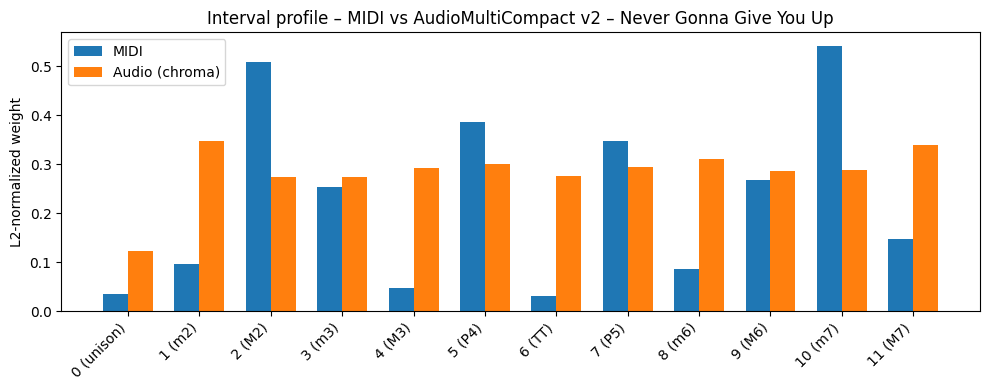

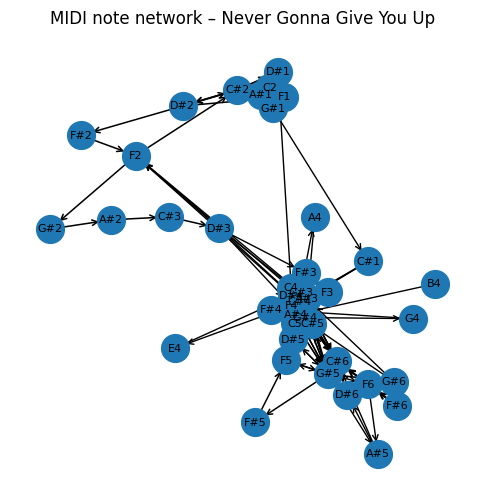

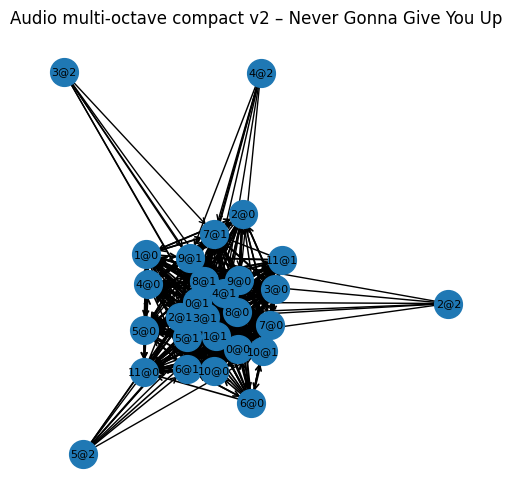

In [104]:
rick_amc2 = compare_midi_vs_amc_v2(
    MIDI_PATH_RICK,
    AUDIO_PATH_RICK,
    label="Never Gonna Give You Up"
)

=== Für Elise (v2) ===


c:\Users\emanu\miniconda3\envs\BasicPy\Lib\site-packages\pretty_midi\pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Cosine similarity (MIDI vs AudioMultiCompact v2): 0.9101432554377262


n_nodes  n_edges   density    r_real  \
piece     domain                                                       
Für Elise MIDI                       56      269  0.087338  0.417123   
          AudioMultiCompact_v2       27      263  0.374644  0.820557   

                                  r_null  rho_norm  mean_entropy  \
piece     domain                                                   
Für Elise MIDI                  0.227626  0.245344      0.534693   
          AudioMultiCompact_v2  0.562890  0.589477      0.925343   

                                eff_unweighted  eff_weighted  
piece     domain                                              
Für Elise MIDI                        0.344194      2.523089  
          AudioMultiCompact_v2        0.720288     17.222658

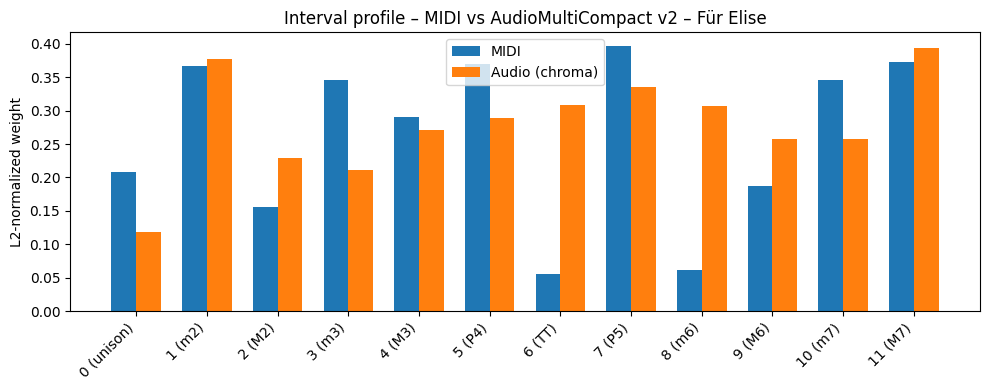

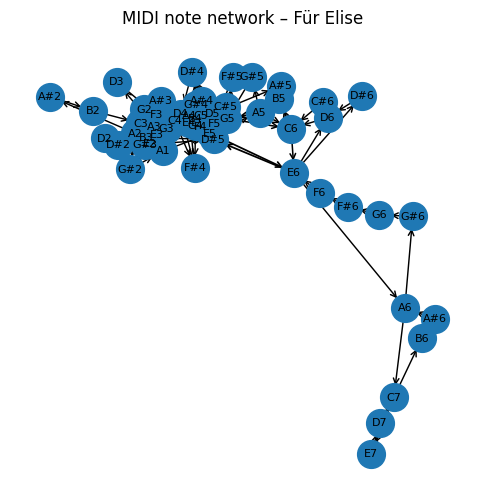

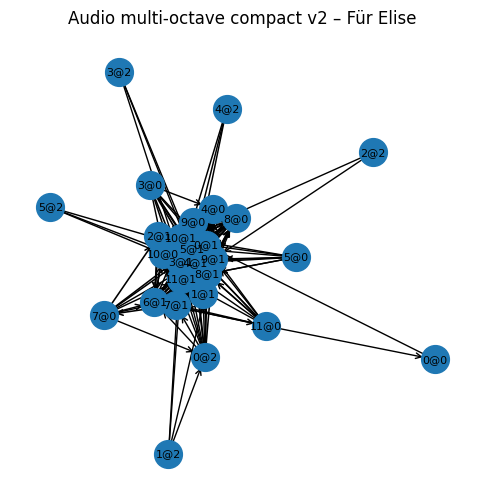

In [105]:
fe_amc2 = compare_midi_vs_amc_v2(
    MIDI_PATH_FE,
    AUDIO_PATH_FE,
    label="Für Elise"
)


In [106]:
# === AudioMulti-Compact v3 config (conservative) ===
AMC_MIN_PERSIST_BEATS = 1      # temporal stability (1 = conservative: almost no removal)
AMC_ALPHA_MAD         = 1.0    # per-pitch median + alpha * MAD
AMC_OCT_COLLAPSE_RATIO = 2.0   # keep only main band if > 2x second band

In [107]:
def multi_octave_chord_sequence_compact_v3(
        y,
        sr=SR,
        n_octaves=AMC_N_OCTAVES,
        base_note=AMC_BASE_NOTE,
        rel_thresh=AMC_REL_THRESH,
        min_global=AMC_MIN_GLOBAL,
        alpha_band=AMC_ALPHA_BAND,
        max_nodes_per_beat=AMC_MAX_NODES_PER_BEAT,
        n_bands=AMC_N_BANDS,
        hop_length=HOP_LENGTH,
):
    """
    AudioMulti-Compact v3 (conservative):
      - HPSS + multi-octave CQT
      - Beat-synchronous aggregation
      - Coarse bands (low/mid/high) x pitch class
      - Per-pitch (across beats) adaptive threshold: median + alpha*MAD
      - Temporal stability filter across beats (min AMC_MIN_PERSIST_BEATS)
      - Harmonic collapse across bands within each pitch class:
            keep main band, and second band only if close in energy
    """

    # 1) HPSS: harmonic component
    y_harm, y_perc = librosa.effects.hpss(y)

    # 2) CQT
    C = librosa.cqt(
        y_harm,
        sr=sr,
        hop_length=hop_length,
        fmin=librosa.note_to_hz(base_note),
        n_bins=n_octaves * 12,
        bins_per_octave=12,
    )
    C_mag = np.abs(C)
    F, T_frames = C_mag.shape
    if F == 0 or T_frames == 0:
        return []

    global_max = C_mag.max()
    if global_max <= 0:
        return []

    # 3) Beat sync
    onset_env = librosa.onset.onset_strength(y=y_harm, sr=sr, hop_length=hop_length)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    if beats.size > 0:
        C_sync = librosa.util.sync(C_mag, beats, aggregate=np.median)
    else:
        C_sync = C_mag

    F, T = C_sync.shape
    if T == 0:
        return []

    # 4) Band/pc mapping
    band_pc_indices = [[[] for _ in range(12)] for _ in range(n_bands)]
    for f_idx in range(F):
        band, pc = _cqt_bin_to_band_pc(f_idx, n_octaves=n_octaves, n_bands=n_bands)
        if 0 <= band < n_bands:
            band_pc_indices[band][pc].append(f_idx)

    # 5) Precompute energies: E_all[band, pc, t] and PC_E[pc, t]
    E_all = np.zeros((n_bands, 12, T), dtype=float)
    frame_maxes = np.zeros(T, dtype=float)

    for t in range(T):
        frame = C_sync[:, t]
        frame_maxes[t] = frame.max()
        for band in range(n_bands):
            for pc in range(12):
                idxs = band_pc_indices[band][pc]
                if idxs:
                    E_all[band, pc, t] = frame[idxs].sum()

    PC_E = E_all.sum(axis=0)  # (12, T)

    # 6) Per-pitch adaptive threshold: median + alpha * MAD (conservative)
    per_pc_thresh = np.full(12, np.inf, dtype=float)
    for pc in range(12):
        vec = PC_E[pc]
        nz = vec[vec > 0]
        if nz.size == 0:
            continue
        med = np.median(nz)
        mad = np.median(np.abs(nz - med))
        if mad == 0:
            mad = 1e-6
        per_pc_thresh[pc] = med + AMC_ALPHA_MAD * mad

    # 7) Raw active mask (before temporal stability)
    active_raw = np.zeros_like(E_all, dtype=bool)

    for t in range(T):
        frame_max = frame_maxes[t]
        if frame_max < min_global * global_max:
            continue

        for band in range(n_bands):
            for pc in range(12):
                e = E_all[band, pc, t]
                if e <= 0:
                    continue
                if e < rel_thresh * frame_max:
                    continue
                if e < per_pc_thresh[pc]:
                    continue
                active_raw[band, pc, t] = True

    # 8) Temporal stability across beats
    min_len = max(1, AMC_MIN_PERSIST_BEATS)  # conservative: 1 (no extra removal)
    active_stable = np.zeros_like(active_raw, dtype=bool)

    for band in range(n_bands):
        for pc in range(12):
            series = active_raw[band, pc, :]
            if not series.any():
                continue
            start = None
            for t in range(T + 1):
                flag = series[t] if t < T else False
                if flag and start is None:
                    start = t
                elif (not flag) and (start is not None):
                    length = t - start
                    if length >= min_len:
                        active_stable[band, pc, start:t] = True
                    start = None

    # 9) Build chords per beat with harmonic collapse + top-K
    chords = []
    prev_chord = None

    for t in range(T):
        idxs = np.argwhere(active_stable[:, :, t])
        if idxs.size == 0:
            chord = ()
        else:
            # collect candidates (pc, band, energy)
            cand = []
            for band, pc in idxs:
                band = int(band)
                pc = int(pc)
                e = E_all[band, pc, t]
                if e > 0:
                    cand.append((pc, band, e))

            if not cand:
                chord = ()
            else:
                # group by pitch class
                pc_groups = {}
                for pc, band, e in cand:
                    pc_groups.setdefault(pc, []).append((band, e))

                reduced = []
                for pc, entries in pc_groups.items():
                    entries.sort(key=lambda x: x[1], reverse=True)
                    main_band, main_e = entries[0]
                    # always keep main band
                    reduced.append((pc, main_band, main_e))

                    # conservative harmonic collapse: keep second band only if close in energy
                    if len(entries) > 1:
                        second_band, second_e = entries[1]
                        if main_e < AMC_OCT_COLLAPSE_RATIO * second_e:
                            reduced.append((pc, second_band, second_e))

                # sort by energy, apply global top-K
                reduced.sort(key=lambda x: x[2], reverse=True)
                nodes = []
                for pc, band, e in reduced[:max_nodes_per_beat]:
                    nodes.append((pc, band))
                chord = tuple(sorted(set(nodes)))

        if chord != prev_chord and len(chord) > 0:
            chords.append(chord)
            prev_chord = chord

    return chords


In [108]:
def compute_audio_multiband_compact_v3_network_metrics(audio_path):
    """
    AudioMulti-Compact v3 network:
      - Uses multi_octave_chord_sequence_compact_v3
      - Applies edge pruning for weak transitions
    """
    y, sr = librosa.load(audio_path, sr=SR, mono=True)

    chords = multi_octave_chord_sequence_compact_v3(y, sr=sr)
    G_raw = build_chord_transition_graph(chords)
    G = prune_graph_by_weight(G_raw)  # same pruning as v2

    metrics = {}
    metrics["n_nodes"] = G.number_of_nodes()
    metrics["n_edges"] = G.number_of_edges()
    metrics["density"] = nx.density(G)

    r_real, r_null, rho = normalized_weighted_reciprocity(G)
    metrics["r_real"] = r_real
    metrics["r_null"] = r_null
    metrics["rho_norm"] = rho

    metrics["mean_entropy"] = mean_node_entropy(G)
    metrics["eff_unweighted"] = global_efficiency_unweighted(G)
    metrics["eff_weighted"] = global_efficiency_weighted(G)

    metrics["interval_vec"] = interval_embedding_12d(G)
    metrics["graph"] = G
    return metrics


In [109]:
def compare_midi_vs_amc_v3(midi_path, audio_path, label="piece"):
    """
    Compare MIDI network vs AudioMulti-Compact v3 network.
    """
    print(f"=== {label} (v3) ===")

    midi_metrics = compute_midi_network_metrics(midi_path)
    amc3_metrics = compute_audio_multiband_compact_v3_network_metrics(audio_path)

    compare_keys = [
        "n_nodes",
        "n_edges",
        "density",
        "r_real",
        "r_null",
        "rho_norm",
        "mean_entropy",
        "eff_unweighted",
        "eff_weighted",
    ]

    rows = []
    for domain, metrics in [("MIDI", midi_metrics), ("AudioMultiCompact_v3", amc3_metrics)]:
        row = {"piece": label, "domain": domain}
        for k in compare_keys:
            row[k] = metrics[k]
        rows.append(row)

    df = pd.DataFrame(rows).set_index(["piece", "domain"])

    iv_midi = midi_metrics["interval_vec"]
    iv_amc3 = amc3_metrics["interval_vec"]

    cosine_sim = float(
        np.dot(iv_midi, iv_amc3) /
        (np.linalg.norm(iv_midi) * np.linalg.norm(iv_amc3) + EPS)
    )

    print("Cosine similarity (MIDI vs AudioMultiCompact v3):", cosine_sim)
    display(df)

    plot_interval_profiles(
        iv_midi,
        iv_amc3,
        title=f"Interval profile – MIDI vs AudioMultiCompact v3 – {label}"
    )

    plot_midi_graph(midi_metrics["graph"], title=f"MIDI note network – {label}")
    plot_multiband_audio_graph(
        amc3_metrics["graph"],
        title=f"Audio multi-octave compact v3 – {label}"
    )

    return {
        "midi": midi_metrics,
        "audio_multicompact_v3": amc3_metrics,
        "df": df,
        "cosine": cosine_sim,
    }


=== Never Gonna Give You Up (v3) ===
Cosine similarity (MIDI vs AudioMultiCompact v3): 0.8628896516082131


n_nodes  n_edges   density  \
piece                   domain                                             
Never Gonna Give You Up MIDI                       41      228  0.139024   
                        AudioMultiCompact_v3       18       85  0.277778   

                                                r_real    r_null  rho_norm  \
piece                   domain                                               
Never Gonna Give You Up MIDI                  0.743737  0.302928  0.632372   
                        AudioMultiCompact_v3  0.487395  0.430672  0.099631   

                                              mean_entropy  eff_unweighted  \
piece                   domain                                               
Never Gonna Give You Up MIDI                      0.615626        0.417628   
                        AudioMultiCompact_v3      0.752572        0.612200   

                                              eff_weighted  
piece                   domain                              
Never Gonna Give You Up MIDI                      3.934737  
                        AudioMultiCompact_v3      1.757018

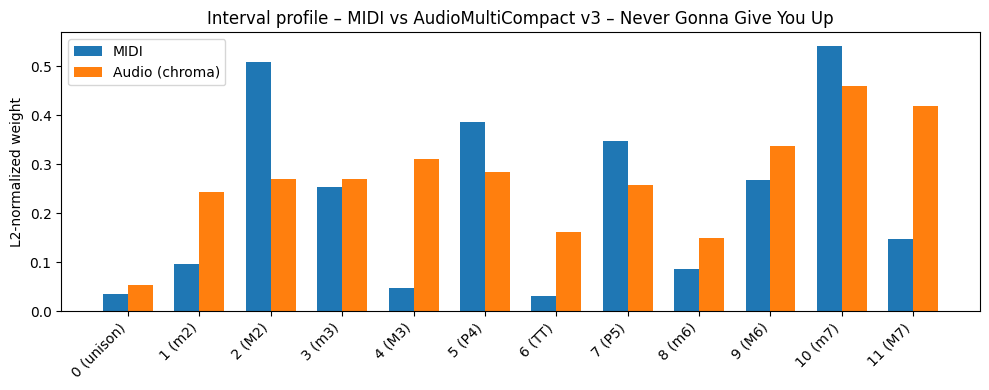

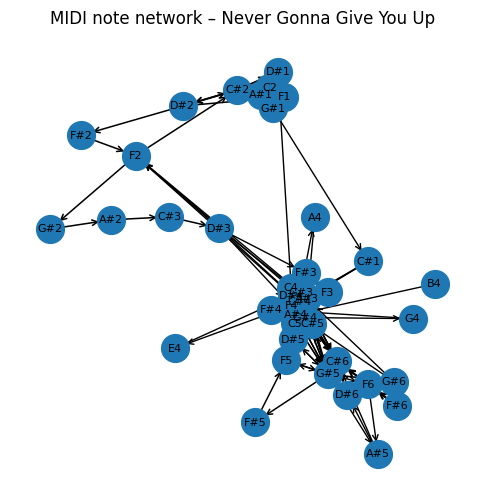

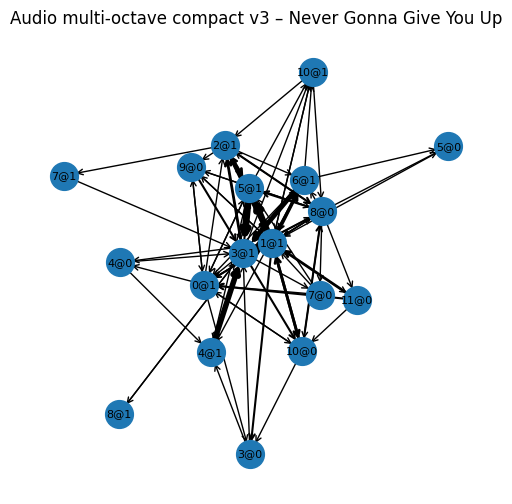

=== Für Elise (v3) ===


c:\Users\emanu\miniconda3\envs\BasicPy\Lib\site-packages\pretty_midi\pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Cosine similarity (MIDI vs AudioMultiCompact v3): 0.9157112272398603


n_nodes  n_edges   density    r_real  \
piece     domain                                                       
Für Elise MIDI                       56      269  0.087338  0.417123   
          AudioMultiCompact_v3       22      218  0.471861  0.735234   

                                  r_null  rho_norm  mean_entropy  \
piece     domain                                                   
Für Elise MIDI                  0.214684  0.257780      0.534693   
          AudioMultiCompact_v3  0.577851  0.372814      0.909016   

                                eff_unweighted  eff_weighted  
piece     domain                                              
Für Elise MIDI                        0.344194      2.523089  
          AudioMultiCompact_v3        0.796399      7.329659

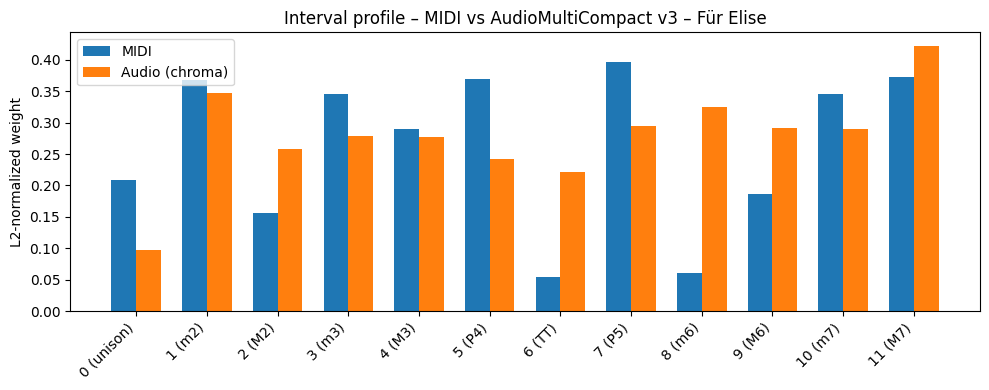

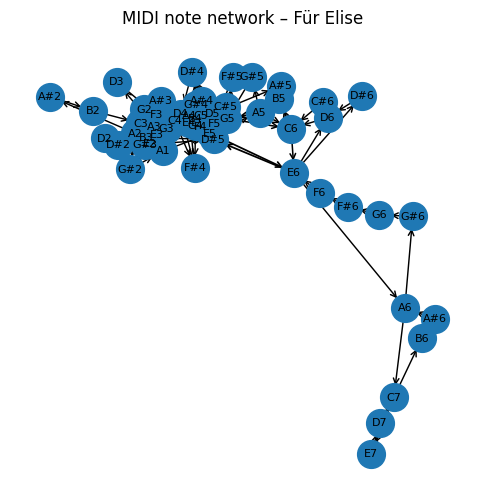

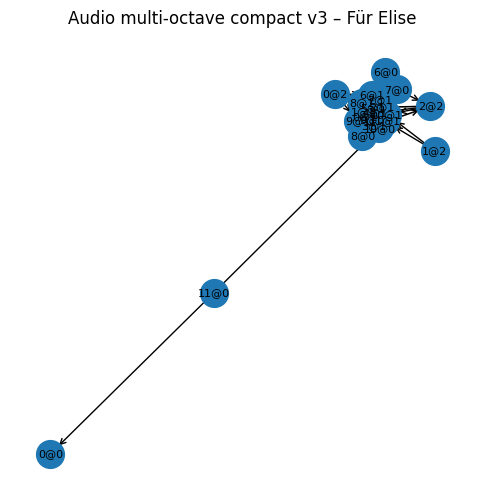

In [110]:
rick_amc3 = compare_midi_vs_amc_v3(
    MIDI_PATH_RICK,
    AUDIO_PATH_RICK,
    label="Never Gonna Give You Up"
)

fe_amc3 = compare_midi_vs_amc_v3(
    MIDI_PATH_FE,
    AUDIO_PATH_FE,
    label="Für Elise"
)


In [111]:
# === AudioMulti-Compact v4: stability-oriented ===
AM4_MIN_PERSIST_BEATS   = 2      # require >= 2 consecutive beats to count as active
AM4_REL_THRESH          = 0.25   # per-beat relative threshold to frame max
AM4_PC_MEDIAN_SCALE     = 0.5    # per-pitch threshold = scale * median energy
AM4_MAX_NODES_PER_BEAT  = 6      # global cap on active (pc, band) per beat
AM4_MAX_BANDS_PER_PC    = 2      # at most 2 registers per pitch class


In [115]:
def multi_octave_chord_sequence_compact_v4(
        y,
        sr=SR,
        n_octaves=AMC_N_OCTAVES,
        base_note=AMC_BASE_NOTE,
        n_bands=AMC_N_BANDS,
        hop_length=HOP_LENGTH,
):
    """
    AudioMulti-Compact v4 (stability-oriented):

      - HPSS + multi-octave CQT
      - Beat-synchronous aggregation
      - Coarse bands (low/mid/high) x pitch class
      - Per-pitch (across beats) threshold = AM4_PC_MEDIAN_SCALE * median energy
      - Temporal stability: require >= AM4_MIN_PERSIST_BEATS consecutive active beats
      - Per-beat: soft relative threshold (AM4_REL_THRESH * frame_max)
      - For each pitch class: keep at most AM4_MAX_BANDS_PER_PC bands (registers)
      - Per beat: cap chord size to AM4_MAX_NODES_PER_BEAT nodes
    """

    # 1) HPSS: harmonic part only
    y_harm, y_perc = librosa.effects.hpss(y)

    # 2) CQT
    C = librosa.cqt(
        y_harm,
        sr=sr,
        hop_length=hop_length,
        fmin=librosa.note_to_hz(base_note),
        n_bins=n_octaves * 12,
        bins_per_octave=12,
    )
    C_mag = np.abs(C)
    F, T_frames = C_mag.shape
    if F == 0 or T_frames == 0:
        return []

    global_max = C_mag.max()
    if global_max <= 0:
        return []

    # 3) Beat sync
    onset_env = librosa.onset.onset_strength(y=y_harm, sr=sr, hop_length=hop_length)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    if beats.size > 0:
        C_sync = librosa.util.sync(C_mag, beats, aggregate=np.median)
    else:
        C_sync = C_mag

    F, T = C_sync.shape
    if T == 0:
        return []

    # 4) Band/pc mapping
    band_pc_indices = [[[] for _ in range(12)] for _ in range(n_bands)]
    for f_idx in range(F):
        band, pc = _cqt_bin_to_band_pc(f_idx, n_octaves=n_octaves, n_bands=n_bands)
        if 0 <= band < n_bands:
            band_pc_indices[band][pc].append(f_idx)

    # 5) Energy tensor E_all[band, pc, t] and per-pitch energies PC_E[pc, t]
    E_all = np.zeros((n_bands, 12, T), dtype=float)
    frame_maxes = np.zeros(T, dtype=float)

    for t in range(T):
        frame = C_sync[:, t]
        frame_maxes[t] = frame.max()
        for band in range(n_bands):
            for pc in range(12):
                idxs = band_pc_indices[band][pc]
                if idxs:
                    E_all[band, pc, t] = frame[idxs].sum()

    PC_E = E_all.sum(axis=0)  # (12, T)

    # 6) Per-pitch median thresholds (across beats)
    per_pc_thresh = np.zeros(12, dtype=float)
    for pc in range(12):
        vec = PC_E[pc]
        nz = vec[vec > 0]
        if nz.size == 0:
            per_pc_thresh[pc] = np.inf  # effectively disable
        else:
            med = np.median(nz)
            per_pc_thresh[pc] = AM4_PC_MEDIAN_SCALE * med

    # 7) Initial active mask based on per-beat and per-pitch thresholds
    active_raw = np.zeros_like(E_all, dtype=bool)

    for t in range(T):
        frame_max = frame_maxes[t]
        if frame_max < AMC_MIN_GLOBAL * global_max:
            continue  # very quiet beat

        beat_rel_thresh = AM4_REL_THRESH * frame_max

        for band in range(n_bands):
            for pc in range(12):
                e = E_all[band, pc, t]
                if e <= 0:
                    continue
                if e < beat_rel_thresh:
                    continue
                if e < per_pc_thresh[pc]:
                    continue
                active_raw[band, pc, t] = True

    # 8) Temporal stability: require >= AM4_MIN_PERSIST_BEATS consecutive beats
    min_len = max(1, AM4_MIN_PERSIST_BEATS)
    active_stable = np.zeros_like(active_raw, dtype=bool)

    for band in range(n_bands):
        for pc in range(12):
            series = active_raw[band, pc, :]
            if not series.any():
                continue
            start = None
            for t in range(T + 1):
                flag = series[t] if t < T else False
                if flag and start is None:
                    start = t
                elif (not flag) and (start is not None):
                    length = t - start
                    if length >= min_len:
                        active_stable[band, pc, start:t] = True
                    start = None

    # 9) Build chords per beat: limit bands per pc + global top-K
    chords = []
    prev_chord = None

    for t in range(T):
        idxs = np.argwhere(active_stable[:, :, t])
        if idxs.size == 0:
            chord = ()
        else:
            # collect (pc, band, energy)
            cand = []
            for band, pc in idxs:
                band = int(band)
                pc = int(pc)
                e = E_all[band, pc, t]
                if e > 0:
                    cand.append((pc, band, e))

            if not cand:
                chord = ()
            else:
                # group by pitch class, keep up to AM4_MAX_BANDS_PER_PC bands per pc
                pc_groups = {}
                for pc, band, e in cand:
                    pc_groups.setdefault(pc, []).append((band, e))

                reduced = []
                for pc, entries in pc_groups.items():
                    entries.sort(key=lambda x: x[1], reverse=True)
                    for band, e in entries[:AM4_MAX_BANDS_PER_PC]:
                        reduced.append((pc, band, e))

                # global top-K by energy
                reduced.sort(key=lambda x: x[2], reverse=True)
                nodes = []
                for pc, band, e in reduced[:AM4_MAX_NODES_PER_BEAT]:
                    nodes.append((pc, band))
                chord = tuple(sorted(set(nodes)))

        if chord != prev_chord and len(chord) > 0:
            chords.append(chord)
            prev_chord = chord

    return chords


In [116]:
def compute_audio_multiband_compact_v4_network_metrics(audio_path):
    """
    AudioMulti-Compact v4 network:
      - Uses multi_octave_chord_sequence_compact_v4
      - Applies edge pruning for weak transitions
    """
    y, sr = librosa.load(audio_path, sr=SR, mono=True)

    chords = multi_octave_chord_sequence_compact_v4(y, sr=sr)
    G_raw = build_chord_transition_graph(chords)
    G = prune_graph_by_weight(G_raw)  # same pruning function as before

    metrics = {}
    metrics["n_nodes"] = G.number_of_nodes()
    metrics["n_edges"] = G.number_of_edges()
    metrics["density"] = nx.density(G)

    r_real, r_null, rho = normalized_weighted_reciprocity(G)
    metrics["r_real"] = r_real
    metrics["r_null"] = r_null
    metrics["rho_norm"] = rho

    metrics["mean_entropy"] = mean_node_entropy(G)
    metrics["eff_unweighted"] = global_efficiency_unweighted(G)
    metrics["eff_weighted"] = global_efficiency_weighted(G)

    metrics["interval_vec"] = interval_embedding_12d(G)
    metrics["graph"] = G
    return metrics


In [118]:
def compare_midi_vs_amc_v4(midi_path, audio_path, label="piece"):
    """
    Compare MIDI network vs AudioMulti-Compact v4 network
    (stability-oriented).
    """
    print(f"=== {label} (v4) ===")

    midi_metrics = compute_midi_network_metrics(midi_path)
    amc4_metrics = compute_audio_multiband_compact_v4_network_metrics(audio_path)

    compare_keys = [
        "n_nodes",
        "n_edges",
        "density",
        "r_real",
        "r_null",
        "rho_norm",
        "mean_entropy",
        "eff_unweighted",
        "eff_weighted",
    ]

    rows = []
    for domain, metrics in [("MIDI", midi_metrics), ("AudioMultiCompact_v4", amc4_metrics)]:
        row = {"piece": label, "domain": domain}
        for k in compare_keys:
            row[k] = metrics[k]
        rows.append(row)

    df = pd.DataFrame(rows).set_index(["piece", "domain"])

    iv_midi = midi_metrics["interval_vec"]
    iv_amc4 = amc4_metrics["interval_vec"]

    cosine_sim = float(
        np.dot(iv_midi, iv_amc4) /
        (np.linalg.norm(iv_midi) * np.linalg.norm(iv_amc4) + EPS)
    )

    print("Cosine similarity (MIDI vs AudioMultiCompact v4):", cosine_sim)
    display(df)

    plot_interval_profiles(
        iv_midi,
        iv_amc4,
        title=f"Interval profile – MIDI vs AudioMultiCompact v4 – {label}"
    )

    plot_midi_graph(midi_metrics["graph"], title=f"MIDI note network – {label}")
    plot_multiband_audio_graph(
        amc4_metrics["graph"],
        title=f"Audio multi-octave compact v4 – {label}"
    )

    return {
        "midi": midi_metrics,
        "audio_multicompact_v4": amc4_metrics,
        "df": df,
        "cosine": cosine_sim,
    }


=== Never Gonna Give You Up (v4) ===
Cosine similarity (MIDI vs AudioMultiCompact v4): 0.7878628888285422


n_nodes  n_edges   density  \
piece                   domain                                             
Never Gonna Give You Up MIDI                       41      228  0.139024   
                        AudioMultiCompact_v4       25      423  0.705000   

                                                r_real    r_null  rho_norm  \
piece                   domain                                               
Never Gonna Give You Up MIDI                  0.743737  0.308331  0.629500   
                        AudioMultiCompact_v4  0.767681  0.601709  0.416712   

                                              mean_entropy  eff_unweighted  \
piece                   domain                                               
Never Gonna Give You Up MIDI                      0.615626        0.417628   
                        AudioMultiCompact_v4      0.928029        0.865741   

                                              eff_weighted  
piece                   domain                              
Never Gonna Give You Up MIDI                      3.934737  
                        AudioMultiCompact_v4     19.427904

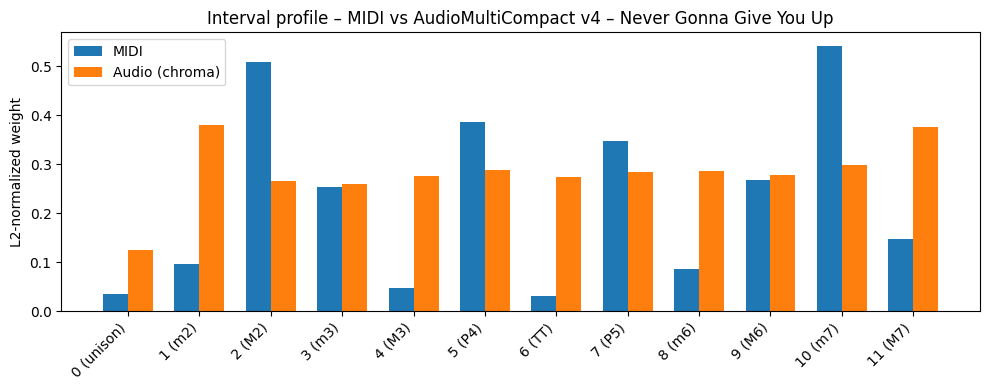

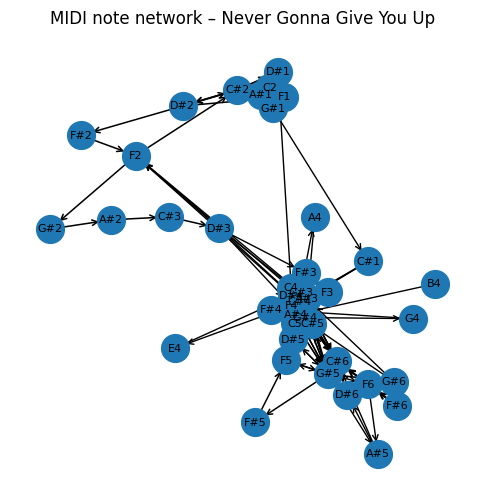

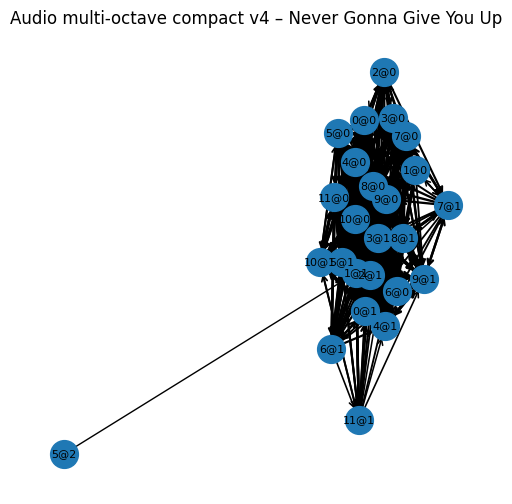

=== Für Elise (v4) ===


c:\Users\emanu\miniconda3\envs\BasicPy\Lib\site-packages\pretty_midi\pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Cosine similarity (MIDI vs AudioMultiCompact v4): 0.9209531630626


n_nodes  n_edges   density    r_real  \
piece     domain                                                       
Für Elise MIDI                       56      269  0.087338  0.417123   
          AudioMultiCompact_v4       24      294  0.532609  0.822555   

                                  r_null  rho_norm  mean_entropy  \
piece     domain                                                   
Für Elise MIDI                  0.239373  0.233689      0.534693   
          AudioMultiCompact_v4  0.590264  0.566929      0.918034   

                                eff_unweighted  eff_weighted  
piece     domain                                              
Für Elise MIDI                        0.344194      2.523089  
          AudioMultiCompact_v4        0.767423     17.533786

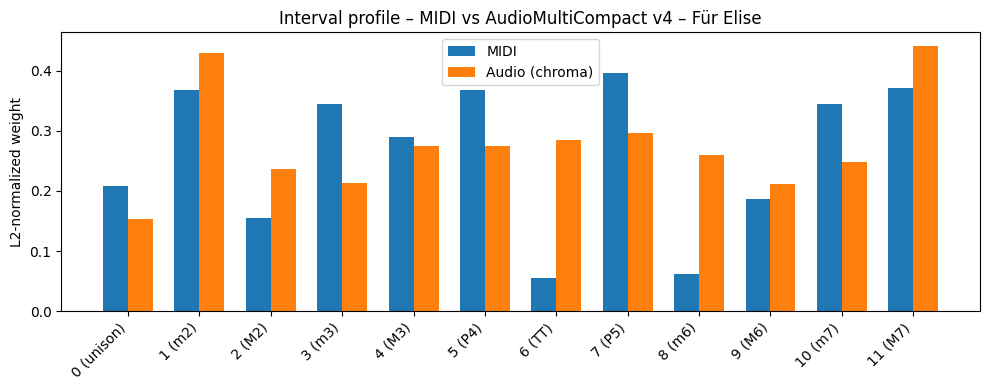

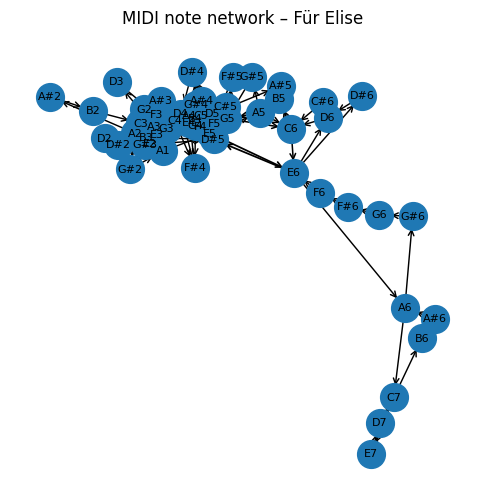

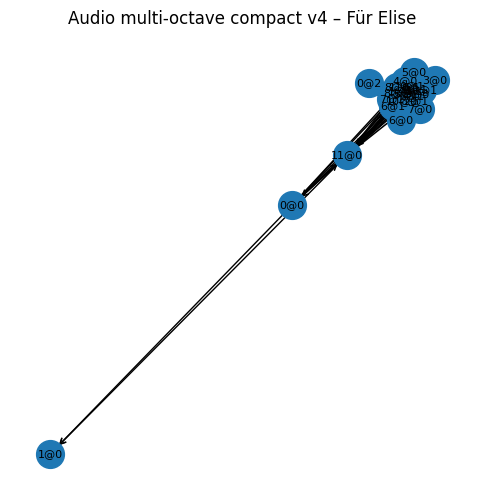

In [119]:
rick_amc4 = compare_midi_vs_amc_v4(
    MIDI_PATH_RICK,
    AUDIO_PATH_RICK,
    label="Never Gonna Give You Up"
)

fe_amc4 = compare_midi_vs_amc_v4(
    MIDI_PATH_FE,
    AUDIO_PATH_FE,
    label="Für Elise"
)
